# Initial Work for Test Network


## Notebook Setup

<div hidden>
$\usepackage{cancel}$
$\usepackage{amssymb}$
</div>

In [1]:
# Required packages
#!pip install "../requirements.txt"

In [2]:
# Visualize tensorboard in the notebook
%load_ext tensorboard
# In order to force reload any changes done to the models package files
%load_ext autoreload
%autoreload 2

In [3]:
## Allow import from our custom lib python files
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path, "lib"))

In [4]:
from models.simpleFork import Simple, Fork
from models.danmf import DANMF
from models.convmf import ConvMF
from datasets.gen_plasma_1d import GenPlasma1DDataset
from framework.saveload import load_checkpoint, load_trained_model
from framework.params import * # device, use_cuda, Checkpoint, various saving strs
from framework.train import train_model

from timeit import default_timer
import re
from datetime import datetime
import json

import torch
import onnx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, diagsvd
from torch import nn
from torch.utils.data import DataLoader, random_split
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch import profiler

### Per-run user defined variables

In [5]:
# Define the machine being used
machine = "Macbook"
# machine = "PC"

# Paths for files
data_dir = os.path.normpath("../../data")
output_dir = os.path.join(data_dir, "output")
tensorboard_dir = os.path.join(output_dir, "tensorboard")

# Dataset params
batch_size = 25
mat_size = [64, 128]
mat_dirs = [os.path.join(data_dir, "gen_plasma_n64", f"mat_{i}") for i in range(3)]

# Device comes from framework.params
print(f"Using {device} device")

Using cpu device


## Data 

We remove the channels in the images (convert to grayscale) to more closely mimic the actual plasma dataset

* [Helpful Link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)


#### Normalization
* Normalize each image with respect to its unit Frobenius norm

### Dataset

In [6]:
# Load and split the data, and prep for being fed into the NN
data = GenPlasma1DDataset(mat_dirs)
# Divide data into train, validation, test
train_data, validation_data, test_data = random_split(data, [0.7, 0.2, 0.1], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=(torch.cuda.is_available()), drop_last=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, pin_memory=(torch.cuda.is_available()), drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

21975 <class 'torch.Tensor'> torch.Size([64, 128])
tensor([[ 1.5490e-09,  1.2974e-08, -1.2685e-09,  ..., -3.1265e-08,
          2.4354e-08, -4.3778e-09],
        [ 8.8028e-09,  6.6438e-09,  1.6978e-08,  ..., -1.7247e-08,
          1.6309e-08,  3.0742e-10],
        [ 1.4042e-08,  5.9671e-09,  2.7655e-08,  ...,  1.7584e-08,
         -6.1634e-10,  7.9415e-09],
        ...,
        [ 2.9151e-10,  1.6614e-08, -1.7626e-08,  ...,  1.8026e-08,
          6.2687e-09,  8.9249e-09],
        [-4.8291e-09,  2.5087e-08, -3.2353e-08,  ..., -1.9762e-09,
          1.3646e-08,  1.1134e-09],
        [-4.2047e-09,  2.1915e-08, -2.2832e-08,  ..., -2.3230e-08,
          2.2154e-08, -4.1802e-09]])


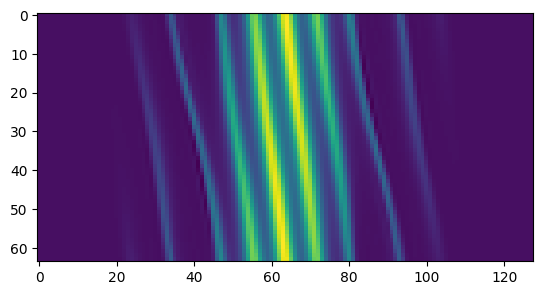

In [7]:
plt.imshow(data[2669])
print(len(data), type(data[0]), data[244].shape)
print(data[2000])

## Hyperparameters


### Structure

#### DANMF Implementation from papers

* **Non-alternating/nonnegative Matrix Factorization (NMF)**: Classical deep NMF for a non-negative matrix X ∈ Rm×n + can be described as follows: first, X is decomposed as X ≈ U0V 0 where U 0 ∈ Rm×r0 +  and V 0 ∈ Rr0×n + . The coding matrix V 0 is then further decomposed as V 0 ≈ U 1V 1 where U 1 ∈ Rr0×r1 +  and V 1 ∈ Rr1×n +. The procedure is repeated until a pre-fixed number of layers is reached. [[2]](#r2)
* **deep alternating non-negative matrix factorisation (DA-NMF)**: we propose to factorise the basis and coding matrices in an alternating order along the layers. [[2]](#r2)
    * Uses approx 6-8 layers

<img src="images/r2_fig1.png" alt="Drawing" style="width: 400px;"/>
<!-- ![image.png](images/r2_fig1.png) -->


### L-System
* Using L (Lindenmayer) Systems to define strucure?
* Node types:
    * Terminating (1 -> 0)
    * Splitting (1 -> 2)
    * Unifying (2 ->1)
    * Direct (1 -> 1)
    * Starting (0 -> 1)


### Loss Function
We use methods defined in [[1]](#r1) to define our loss function <!-- $\mathcal{L}$ \\ -->

$$
\min_{\substack{U \in \real^{m\times r} \\ V \in \real^{r\times n}}} ||X - ReLU(UV)||^2_F ,
$$
Where we are finding the square Frobenius norm of the difference between the original matrix $X$ and the rectified linear low rank representation matrices $UV$

#### From paper

Eq. 10-11 [[2]](#r2)



### Optimizer

Adam works fine / is standard



## Model Definition

### Multiple models hyperparams

In [8]:
## Params
ranks = [6, 12]

stem_layer_dims = [500, 200]

fork_layer_dims = [200, 300]

conv_dims = [[5, 1, 3, 1], [3, 1, 0, 1]]

run_params = dict(
                epochs=120,
                checkpoint_at=40,
                batch_pr=40,
                batch_size=batch_size,
                runname="plasma_mf_test_1"
                )


# Save details
run_details = {"run_params": run_params}
runname = run_details["run_params"]["runname"]
output_run_dir = os.path.join(output_dir, f"run_{runname}")

### Models Creation

In [9]:
models = []

for r in ranks:
    m = Fork(r, mat_size, stem_layer_dims, fork_layer_dims).to(device)
    print(f"{m.get_name()} \trank = {r} \t sl={stem_layer_dims} \t fl={fork_layer_dims} \tcl={0}")
    models.append(m)
    run_details[m.get_name()] = m.get_hyperparameters()

    m = ConvMF(r, mat_size, stem_layer_dims, fork_layer_dims, conv_dims).to(device)
    print(f"{m.get_name()} \trank = {r} \t sl={stem_layer_dims} \t fl={fork_layer_dims} \tcl={conv_dims}")
    models.append(m)
    run_details[m.get_name()] = m.get_hyperparameters()

# m = Fork(nn_rank, img_size, stem_layer_dims[0], fork_layer_dims[0]).to(device)
# print(f"{m.get_name()} \trank = {nn_rank}, \tcl={0} \t sl={stem_layer_dims[0]}, \t fl={fork_layer_dims[0]}")
# models.append(m)
# run_details[m.get_name()] = m.get_hyperparameters()
# for i, cl in enumerate(conv_dims):
#     if i == 0:
#         for sl in stem_layer_dims:
#             for fl in fork_layer_dims:
#                 m = ConvMF(nn_rank, img_size, sl, fl, cl).to(device)
#                 print(f"{m.get_name()} \trank = {nn_rank}, \tcl={cl} \t sl={sl}, \t fl={fl}")
#                 models.append(m)
#                 run_details[m.get_name()] = m.get_hyperparameters()
#     else:
#         m = ConvMF(nn_rank, img_size, stem_layer_dims[0], fork_layer_dims[0], cl).to(device)
#         print(f"{m.get_name()} \trank = {nn_rank}, \tcl={cl} \t sl={stem_layer_dims[0]}, \t fl={fork_layer_dims[0]}")
#         models.append(m)
#         run_details[m.get_name()] = m.get_hyperparameters()

Fork_img64_sdim2-3ebc_fdim2-37e7 	rank = 6 	 sl=[500, 200] 	 fl=[200, 300] 	cl=0
ConvMF_img64_cdim2-c00f 	rank = 6 	 sl=[500, 200] 	 fl=[200, 300] 	cl=[[5, 1, 3, 1], [3, 1, 0, 1]]
Fork_r12_img64_sdim2-3ebc_fdim2-37e7 	rank = 12 	 sl=[500, 200] 	 fl=[200, 300] 	cl=0
ConvMF_r12_img64_cdim2-c00f 	rank = 12 	 sl=[500, 200] 	 fl=[200, 300] 	cl=[[5, 1, 3, 1], [3, 1, 0, 1]]


## Run models

In [10]:
run_details

{'run_params': {'epochs': 120,
  'checkpoint_at': 40,
  'batch_pr': 40,
  'batch_size': 25,
  'runname': 'plasma_mf_test_1'},
 'Fork_img64_sdim2-3ebc_fdim2-37e7': {'stem_layer_dims': [500, 200],
  'fork_layer_dims': [200, 300],
  'rank': 6,
  'img_size': [64, 128],
  'desc': 'Linear layers that fork into two separate channels for U, V'},
 'ConvMF_img64_cdim2-c00f': {'conv_dims': [[5, 1, 3, 1], [3, 1, 0, 1]],
  'stem_layer_dims': [500, 200],
  'fork_layer_dims': [200, 300],
  'rank': 6,
  'img_size': [64, 128],
  'desc': 'Conv layer(s) into Fork model'},
 'Fork_r12_img64_sdim2-3ebc_fdim2-37e7': {'stem_layer_dims': [500, 200],
  'fork_layer_dims': [200, 300],
  'rank': 12,
  'img_size': [64, 128],
  'desc': 'Linear layers that fork into two separate channels for U, V'},
 'ConvMF_r12_img64_cdim2-c00f': {'conv_dims': [[5, 1, 3, 1], [3, 1, 0, 1]],
  'stem_layer_dims': [500, 200],
  'fork_layer_dims': [200, 300],
  'rank': 12,
  'img_size': [64, 128],
  'desc': 'Conv layer(s) into Fork model

In [11]:
if not os.path.exists(output_run_dir):
    os.mkdir(output_run_dir)

# Save details
with open(os.path.join(output_run_dir, f"details_{runname}.json"), "w" ) as write:
    json.dump(run_details, write, indent=2 )


for model in models:
    writer = SummaryWriter(os.path.join(tensorboard_dir, f'{machine}_{model.get_name()}_{runname}'))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    train_model(model=model, 
                optimizer=optimizer,
                train_data=train_dataloader,
                validate_data=validation_dataloader,
                output_run_dir=output_run_dir,
                **run_details["run_params"], 
                writer=writer, 
                load=False
               )
    writer.close()

Training Fork_img64_sdim2-3ebc_fdim2-37e7


[0, 40] loss: 88.90841999053956, validation loss: 37.80822213309152, average train time (sec): 0.0007664845754334238


[0, 80] loss: 27.34197564125061, validation loss: 23.449861967904226, average train time (sec): 0.0006440709752496332


[0, 120] loss: 22.400000905990602, validation loss: 22.047472850254604, average train time (sec): 0.0007656369503820315


[0, 160] loss: 21.613133573532103, validation loss: 21.012348420279366, average train time (sec): 0.0007229911752801854


[0, 200] loss: 19.46508393287659, validation loss: 17.38045914241246, average train time (sec): 0.0006265741503739264


[0, 240] loss: 12.837765502929688, validation loss: 9.205950104849679, average train time (sec): 0.0007132093996915501


[0, 280] loss: 7.529519772529602, validation loss: 6.24581063406808, average train time (sec): 0.0006028531002812088


[0, 320] loss: 5.630733871459961, validation loss: 5.172166355678013, average train time (sec): 0.0005838052748003975


[0, 360] loss: 5.007627636194229, validation loss: 4.5875644247872485, average train time (sec): 0.0005895024500205181


[0, 400] loss: 4.323717170953751, validation loss: 4.193831146785191, average train time (sec): 0.0006133919254352804


[0, 440] loss: 4.016071927547455, validation loss: 3.9293479006631036, average train time (sec): 0.0008053077253862284


[0, 480] loss: 3.7841224908828734, validation loss: 3.713055520738874, average train time (sec): 0.0005847766500664875


[0, 520] loss: 3.5613170862197876, validation loss: 3.504421078818185, average train time (sec): 0.0008882336747774389


[0, 560] loss: 3.2909210920333862, validation loss: 3.334619914463588, average train time (sec): 0.0008470517248497344


[0, 600] loss: 3.2802424669265746, validation loss: 3.2172563988821845, average train time (sec): 0.0005755338497692719


[1, 40] loss: 3.063846653699875, validation loss: 2.9952116755076816, average train time (sec): 0.0008886947747669183


[1, 80] loss: 2.940359538793564, validation loss: 2.8927753189631873, average train time (sec): 0.0007226806999824475


[1, 120] loss: 2.8336694061756136, validation loss: 2.741609939166478, average train time (sec): 0.0006421929749194533


[1, 160] loss: 2.610517629981041, validation loss: 2.624932317052569, average train time (sec): 0.0005573041744355578


[1, 200] loss: 2.585028123855591, validation loss: 2.493715428624834, average train time (sec): 0.0006501849005871918


[1, 240] loss: 2.443358728289604, validation loss: 2.392031361034938, average train time (sec): 0.0007827850749890786


[1, 280] loss: 2.4236465632915496, validation loss: 2.4948965617588588, average train time (sec): 0.0006122781247540843


[1, 320] loss: 2.272894448041916, validation loss: 2.191875936644418, average train time (sec): 0.0005657194000377785


[1, 360] loss: 2.1079914033412934, validation loss: 2.080091927392142, average train time (sec): 0.0005945157499809284


[1, 400] loss: 2.1190017074346543, validation loss: 2.016596587044852, average train time (sec): 0.0006203453500347678


[1, 440] loss: 1.9816926717758179, validation loss: 1.9450599554606847, average train time (sec): 0.0006789574748836458


[1, 480] loss: 1.9411545127630234, validation loss: 1.906830189568656, average train time (sec): 0.0005994067505525891


[1, 520] loss: 1.8840432971715928, validation loss: 1.8535327788761684, average train time (sec): 0.0006196589500177651


[1, 560] loss: 1.790048173069954, validation loss: 1.8102794524601529, average train time (sec): 0.0006370815754053183


[1, 600] loss: 1.7422637522220612, validation loss: 1.811939572606768, average train time (sec): 0.0006448960994021036


[2, 40] loss: 1.7782059341669083, validation loss: 1.7206777054922922, average train time (sec): 0.0008999580000818242


[2, 80] loss: 1.6110325902700424, validation loss: 1.7010399518694197, average train time (sec): 0.0008799133254797197


[2, 120] loss: 1.683999663591385, validation loss: 1.6448600210462299, average train time (sec): 0.0006302387002506294


[2, 160] loss: 1.6297620043158532, validation loss: 1.5943870878219604, average train time (sec): 0.0005626421501801815


[2, 200] loss: 1.5357848763465882, validation loss: 1.537220299584525, average train time (sec): 0.0006420111749321222


[2, 240] loss: 1.5245448350906372, validation loss: 1.4781109714508056, average train time (sec): 0.0008499100993503816


[2, 280] loss: 1.4701211273670196, validation loss: 1.5023479611533028, average train time (sec): 0.0005697347747627646


[2, 320] loss: 1.5735230922698975, validation loss: 1.5097918101719447, average train time (sec): 0.0006553927247296088


[2, 360] loss: 1.4503708004951477, validation loss: 1.461763755934579, average train time (sec): 0.0006327247756416909


[2, 400] loss: 1.455581858754158, validation loss: 1.3635706322533743, average train time (sec): 0.0005658724752720445


[2, 440] loss: 1.3476560443639756, validation loss: 1.307124375275203, average train time (sec): 0.0006987995497183874


[2, 480] loss: 1.3030818477272987, validation loss: 1.29189300094332, average train time (sec): 0.000661404224956641


[2, 520] loss: 1.3217849761247635, validation loss: 1.2871171794618879, average train time (sec): 0.0008027100004255772


[2, 560] loss: 1.2554901093244553, validation loss: 1.2279532957077026, average train time (sec): 0.0006908855502842925


[2, 600] loss: 1.303427129983902, validation loss: 1.3356732310567583, average train time (sec): 0.000633045024733292


[3, 40] loss: 1.2630202934145927, validation loss: 1.2026145556994847, average train time (sec): 0.0005811217743030284


[3, 80] loss: 1.1612794131040574, validation loss: 1.1850467256137303, average train time (sec): 0.0006594763253815472


[3, 120] loss: 1.14804760068655, validation loss: 1.1479152137892588, average train time (sec): 0.0005710444755095522


[3, 160] loss: 1.2657506197690964, validation loss: 1.3344690482957022, average train time (sec): 0.0006195674250193406


[3, 200] loss: 1.2134983509778976, validation loss: 1.1763627903802054, average train time (sec): 0.0006758883748261724


[3, 240] loss: 1.0851472899317742, validation loss: 1.0976798626354762, average train time (sec): 0.0005714356753742323


[3, 280] loss: 1.1241108760237695, validation loss: 1.0975350962366377, average train time (sec): 0.0005486600995936897


[3, 320] loss: 1.0872459694743157, validation loss: 1.0490706545966013, average train time (sec): 0.0005485675756062847


[3, 360] loss: 1.0287191540002822, validation loss: 1.0390448543003628, average train time (sec): 0.0006237618246814236


[3, 400] loss: 1.0116661980748176, validation loss: 1.053761851106371, average train time (sec): 0.000723165724775754


[3, 440] loss: 1.056754569709301, validation loss: 1.0484859650475638, average train time (sec): 0.0005578782249358483


[3, 480] loss: 1.0635707467794417, validation loss: 0.9944840284756252, average train time (sec): 0.0006689684254524763


[3, 520] loss: 0.9999223440885544, validation loss: 0.9604516604968479, average train time (sec): 0.0005549713503569364


[3, 560] loss: 0.990130016207695, validation loss: 0.9854537779944283, average train time (sec): 0.0007386305747786537


[3, 600] loss: 0.9474203392863274, validation loss: 0.9365389588900975, average train time (sec): 0.0006182586497743614


[4, 40] loss: 0.8925585106015206, validation loss: 0.9062076537949698, average train time (sec): 0.0005894201502087526


[4, 80] loss: 0.9076126411557197, validation loss: 0.9169489189556667, average train time (sec): 0.0006337922750390135


[4, 120] loss: 0.9229907751083374, validation loss: 0.9249392352785383, average train time (sec): 0.0005780771003628616


[4, 160] loss: 0.9855796083807945, validation loss: 0.9276546011652266, average train time (sec): 0.0016049221252615099


[4, 200] loss: 0.9647173225879669, validation loss: 0.924515403679439, average train time (sec): 0.001367573725292459


[4, 240] loss: 0.9444181263446808, validation loss: 0.9953767350741796, average train time (sec): 0.0013525387497793418


[4, 280] loss: 0.9821630641818047, validation loss: 0.9293392368725368, average train time (sec): 0.001301694924768526


[4, 320] loss: 0.9406943023204803, validation loss: 1.087112147126879, average train time (sec): 0.0012490159504523035


[4, 360] loss: 0.9472436428070068, validation loss: 0.8833402333940779, average train time (sec): 0.0005607115497696213


[4, 400] loss: 0.853977820277214, validation loss: 0.8852163072994778, average train time (sec): 0.0020034985747770405


[4, 440] loss: 0.8760585069656373, validation loss: 0.812744356904711, average train time (sec): 0.0005741861750721


[4, 480] loss: 0.7962954729795456, validation loss: 0.7996964526176452, average train time (sec): 0.0025479748750512955


[4, 520] loss: 0.7580272510647774, validation loss: 0.7985956840855735, average train time (sec): 0.00208308032451896


[4, 560] loss: 0.8336037695407867, validation loss: 0.8387990423611232, average train time (sec): 0.0006352562995743938


[4, 600] loss: 0.8210642665624619, validation loss: 0.7847775062492915, average train time (sec): 0.0014447891000600066


[5, 40] loss: 0.742113534361124, validation loss: 0.7659331391538893, average train time (sec): 0.0007082506745064165


[5, 80] loss: 0.7882758140563965, validation loss: 0.7918650003841945, average train time (sec): 0.0018482377250620629


[5, 120] loss: 0.8493494719266892, validation loss: 0.8164109441212245, average train time (sec): 0.0014532553250319324


[5, 160] loss: 0.8072498127818107, validation loss: 0.8543802956172398, average train time (sec): 0.0013563449996581768


[5, 200] loss: 0.7748641401529313, validation loss: 0.7626607464041029, average train time (sec): 0.0014359473752847407


[5, 240] loss: 0.7705290213227272, validation loss: 0.7565962042127337, average train time (sec): 0.0013665242498973385


[5, 280] loss: 0.7807988047599792, validation loss: 0.7492074876172202, average train time (sec): 0.0005699608496797737


[5, 320] loss: 0.7566477045416832, validation loss: 0.7589744859082358, average train time (sec): 0.001528595200215932


[5, 360] loss: 0.7260362491011619, validation loss: 0.7385630704675402, average train time (sec): 0.001484555099159479


[5, 400] loss: 0.7784469738602638, validation loss: 0.7775494320052011, average train time (sec): 0.001815039149369113


[5, 440] loss: 0.8056788071990013, validation loss: 0.7750151297024318, average train time (sec): 0.0013456105996738188


[5, 480] loss: 0.7287478759884835, validation loss: 0.6973204292569841, average train time (sec): 0.0015350029745604843


[5, 520] loss: 0.676251282542944, validation loss: 0.7045805180072784, average train time (sec): 0.0014651420497102663


[5, 560] loss: 0.6980733312666416, validation loss: 0.6895412032944815, average train time (sec): 0.001619587725144811


[5, 600] loss: 0.7166968002915383, validation loss: 0.716721807547978, average train time (sec): 0.0006262192488065921


[6, 40] loss: 0.8107477053999901, validation loss: 0.8074676101548331, average train time (sec): 0.0005502666259417311


[6, 80] loss: 0.7861968487501144, validation loss: 0.8314996811321803, average train time (sec): 0.0006850269754067994


[6, 120] loss: 0.7239371374249458, validation loss: 0.7027500585147313, average train time (sec): 0.0009032789006596431


[6, 160] loss: 0.6598537258803845, validation loss: 0.6592125373227256, average train time (sec): 0.0006478019247879274


[6, 200] loss: 0.6347819082438946, validation loss: 0.6620442320619311, average train time (sec): 0.0006609117743209935


[6, 240] loss: 0.6871616825461387, validation loss: 0.66026359132358, average train time (sec): 0.0006328903997200541


[6, 280] loss: 0.7054725237190723, validation loss: 0.729669110264097, average train time (sec): 0.0006759280760888942


[6, 320] loss: 0.7447920933365821, validation loss: 0.6936252973760877, average train time (sec): 0.0006405382751836442


[6, 360] loss: 0.6662293314933777, validation loss: 0.6437677145004272, average train time (sec): 0.0012854973247158341


[6, 400] loss: 0.6532326497137546, validation loss: 0.6465406336103167, average train time (sec): 0.0006769967993022874


[6, 440] loss: 0.6557270497083664, validation loss: 0.7030335867404938, average train time (sec): 0.0006999998251558282


[6, 480] loss: 0.7431373536586762, validation loss: 0.6795802790778024, average train time (sec): 0.0006722774254740216


[6, 520] loss: 0.6749776005744934, validation loss: 0.6666834781851088, average train time (sec): 0.0009651079250033945


[6, 560] loss: 0.6864508196711541, validation loss: 0.6508517105238778, average train time (sec): 0.000832244950288441


[6, 600] loss: 0.6427934259176254, validation loss: 0.6561988188539233, average train time (sec): 0.0007379482747637666


[7, 40] loss: 0.6889211229979992, validation loss: 0.8336905350003924, average train time (sec): 0.0008390583752770908


[7, 80] loss: 0.7263704083859921, validation loss: 0.7003866107123239, average train time (sec): 0.0006782796001061798


[7, 120] loss: 0.6398857317864894, validation loss: 0.6264105413641249, average train time (sec): 0.0007159512504586018


[7, 160] loss: 0.6006600335240364, validation loss: 0.6024439125401633, average train time (sec): 0.0006779668998206035


[7, 200] loss: 0.6121401436626911, validation loss: 0.5900749567576817, average train time (sec): 0.0007056490750983358


[7, 240] loss: 0.5738345935940743, validation loss: 0.5828068586758205, average train time (sec): 0.0005340824747690931


[7, 280] loss: 0.6238734975457192, validation loss: 0.6161891242436001, average train time (sec): 0.0006922154745552689


[7, 320] loss: 0.6656456343829632, validation loss: 0.7562299479757036, average train time (sec): 0.0005564129241975024


[7, 360] loss: 0.6770103648304939, validation loss: 0.6159893814155034, average train time (sec): 0.0005517903497093357


[7, 400] loss: 0.5951327890157699, validation loss: 0.6191643093313489, average train time (sec): 0.0006015482489601709


[7, 440] loss: 0.6048289127647877, validation loss: 0.6302553505556924, average train time (sec): 0.0005509753755177371


[7, 480] loss: 0.5940530925989151, validation loss: 0.6056906042780195, average train time (sec): 0.0006036904494976624


[7, 520] loss: 0.6216632694005966, validation loss: 0.6346714610712869, average train time (sec): 0.0005410542755271309


[7, 560] loss: 0.5780806936323643, validation loss: 0.5907628871713366, average train time (sec): 0.0005733252997742966


[7, 600] loss: 0.5533256240189075, validation loss: 0.5709271224907466, average train time (sec): 0.0006006809489917941


[8, 40] loss: 0.566394978761673, validation loss: 0.5726652325902666, average train time (sec): 0.0005417410502559505


[8, 80] loss: 0.592145736515522, validation loss: 0.7562898073877607, average train time (sec): 0.0005926876750891097


[8, 120] loss: 0.9518194496631622, validation loss: 0.7398580549444471, average train time (sec): 0.000553124824364204


[8, 160] loss: 0.6645855218172073, validation loss: 0.590501571382795, average train time (sec): 0.0006077476238715463


[8, 200] loss: 0.5635064832866192, validation loss: 0.5609695189339774, average train time (sec): 0.0005583852005656808


[8, 240] loss: 0.5285193972289562, validation loss: 0.5545405728476388, average train time (sec): 0.0005589965498074889


[8, 280] loss: 0.5374517813324928, validation loss: 0.5481601703166962, average train time (sec): 0.0008712070237379521


[8, 320] loss: 0.5498997211456299, validation loss: 0.5377522240366255, average train time (sec): 0.0006244129748665727


[8, 360] loss: 0.575929406285286, validation loss: 0.5391147199698857, average train time (sec): 0.0006749061751179398


[8, 400] loss: 0.5304179526865482, validation loss: 0.5554003184182303, average train time (sec): 0.0005714822997106239


[8, 440] loss: 0.5699590191245079, validation loss: 0.5465412654195513, average train time (sec): 0.000543498901242856


[8, 480] loss: 0.551948719471693, validation loss: 0.5692675455978938, average train time (sec): 0.0005440965498564765


[8, 520] loss: 0.5817565813660621, validation loss: 0.7095631810597011, average train time (sec): 0.0005721838751924224


[8, 560] loss: 0.6932264119386673, validation loss: 0.6821932080813816, average train time (sec): 0.0005529350746655837


[8, 600] loss: 0.718561838567257, validation loss: 0.6434092371804374, average train time (sec): 0.0005456330749439075


[9, 40] loss: 0.6429732747375965, validation loss: 0.5530757662228175, average train time (sec): 0.000664119649445638


[9, 80] loss: 0.5282357588410378, validation loss: 0.5221217642511641, average train time (sec): 0.0006332940494758077


[9, 120] loss: 0.5149018213152885, validation loss: 0.5348192499365125, average train time (sec): 0.0006725474493578076


[9, 160] loss: 0.5058391071856022, validation loss: 0.5420571528162275, average train time (sec): 0.0005910027495701798


[9, 200] loss: 0.5172025829553604, validation loss: 0.5178236763817924, average train time (sec): 0.000537538125354331


[9, 240] loss: 0.5210313193500042, validation loss: 0.5144640604087285, average train time (sec): 0.0005268225489999167


[9, 280] loss: 0.5279707632958889, validation loss: 0.5181275510787964, average train time (sec): 0.0005802423998829909


[9, 320] loss: 0.5116341806948185, validation loss: 0.5068238392898015, average train time (sec): 0.0007215780002297834


[9, 360] loss: 0.5039208725094795, validation loss: 0.5063437839916775, average train time (sec): 0.0005399224508437328


[9, 400] loss: 0.5968768067657948, validation loss: 0.6587025361401694, average train time (sec): 0.0006249711004784331


[9, 440] loss: 0.6020005278289318, validation loss: 0.5664174973964691, average train time (sec): 0.0005522657753317617


[9, 480] loss: 0.53082510009408, validation loss: 0.5296625076021467, average train time (sec): 0.0005652381252730266


[9, 520] loss: 0.5110654689371585, validation loss: 0.5215927536146981, average train time (sec): 0.0006981532002100721


[9, 560] loss: 0.5259700581431389, validation loss: 0.5116888109275273, average train time (sec): 0.0007135746243875473


[9, 600] loss: 0.5648876644670964, validation loss: 0.6140640725408282, average train time (sec): 0.0005372214509407058


[10, 40] loss: 0.6899419993162155, validation loss: 0.6345518435750689, average train time (sec): 0.0005882242257939652


[10, 80] loss: 0.5604399800300598, validation loss: 0.5127971531663622, average train time (sec): 0.000763934625138063


[10, 120] loss: 0.4916300542652607, validation loss: 0.4940317588193076, average train time (sec): 0.0007140432746382431


[10, 160] loss: 0.5012350060045719, validation loss: 0.4934127334186009, average train time (sec): 0.0009904638995067217


[10, 200] loss: 0.5016401439905167, validation loss: 0.4916889439310346, average train time (sec): 0.0008654229503008537


[10, 240] loss: 0.4928703740239143, validation loss: 0.5416950416564942, average train time (sec): 0.0005558794000535272


[10, 280] loss: 0.522424153983593, validation loss: 0.500508873292378, average train time (sec): 0.0005527816247195005


[10, 320] loss: 0.4807791255414486, validation loss: 0.49093434844698225, average train time (sec): 0.0005681901762727648


[10, 360] loss: 0.5032411016523838, validation loss: 0.4768502492564065, average train time (sec): 0.0005532781506190076


[10, 400] loss: 0.4805475652217865, validation loss: 0.47685864193098887, average train time (sec): 0.0006045398753485642


[10, 440] loss: 0.46672593951225283, validation loss: 0.5050038456916809, average train time (sec): 0.0006731243993272074


[10, 480] loss: 0.5094812653958798, validation loss: 0.506913160937173, average train time (sec): 0.0008135704003507272


[10, 520] loss: 0.5116947092115879, validation loss: 0.5221180212497711, average train time (sec): 0.0006313607736956328


[10, 560] loss: 0.5268916167318821, validation loss: 0.6006362458637783, average train time (sec): 0.0006372049756464548


[10, 600] loss: 0.5690008454024792, validation loss: 0.544699901001794, average train time (sec): 0.0005654865497490391


[11, 40] loss: 0.5836463950574398, validation loss: 0.5280150733675275, average train time (sec): 0.0005467989001772366


[11, 80] loss: 0.5915447652339936, validation loss: 0.6052839916093009, average train time (sec): 0.0005810806746012531


[11, 120] loss: 0.5658983238041401, validation loss: 0.5075601536887032, average train time (sec): 0.0006890416756505146


[11, 160] loss: 0.484106270223856, validation loss: 0.4869586489881788, average train time (sec): 0.0006014344748109579


[11, 200] loss: 0.47770885527133944, validation loss: 0.46333079474312916, average train time (sec): 0.000581243124906905


[11, 240] loss: 0.4455134361982346, validation loss: 0.4632641099180494, average train time (sec): 0.0006241453505936079


[11, 280] loss: 0.467928571999073, validation loss: 0.45866461379187445, average train time (sec): 0.0005737094499636442


[11, 320] loss: 0.4893233314156532, validation loss: 0.4687396696635655, average train time (sec): 0.0007148633012548089


[11, 360] loss: 0.4824359767138958, validation loss: 0.46143805963652473, average train time (sec): 0.0005896635993849486


[11, 400] loss: 0.4629104495048523, validation loss: 0.4586257142680032, average train time (sec): 0.0006017659252393059


[11, 440] loss: 0.4849622450768948, validation loss: 0.4650647461414337, average train time (sec): 0.0005643654250889086


[11, 480] loss: 0.4677346348762512, validation loss: 0.4963234967844827, average train time (sec): 0.000607128199771978


[11, 520] loss: 0.49141627699136736, validation loss: 0.5166375705174038, average train time (sec): 0.0007007918757153675


[11, 560] loss: 0.5760528832674027, validation loss: 0.6192946154730661, average train time (sec): 0.0007460358247044496


[11, 600] loss: 0.6359311453998089, validation loss: 0.610435859135219, average train time (sec): 0.0006183293749927543


[12, 40] loss: 0.5322645753622055, validation loss: 0.48073463933808463, average train time (sec): 0.0007499465005821549


[12, 80] loss: 0.45055696442723275, validation loss: 0.4507193505764008, average train time (sec): 0.0006199423500220291


[12, 120] loss: 0.4476425006985664, validation loss: 0.4415035821710314, average train time (sec): 0.0006129614252131432


[12, 160] loss: 0.4320987768471241, validation loss: 0.4548645772252764, average train time (sec): 0.000627690099645406


[12, 200] loss: 0.44642536491155627, validation loss: 0.44063287036759513, average train time (sec): 0.0006762260003597475


[12, 240] loss: 0.4473570786416531, validation loss: 0.45865267719541275, average train time (sec): 0.0006109332010964863


[12, 280] loss: 0.45806567147374155, validation loss: 0.4637687567302159, average train time (sec): 0.0007608257990796119


[12, 320] loss: 0.517097894102335, validation loss: 0.4918855241366795, average train time (sec): 0.0007973940242663957


[12, 360] loss: 0.4891821250319481, validation loss: 0.5428130972385407, average train time (sec): 0.0006100659258663655


[12, 400] loss: 0.5183899983763695, validation loss: 0.5271967697143555, average train time (sec): 0.0005703229995560833


[12, 440] loss: 0.5556201040744781, validation loss: 0.4945032404150282, average train time (sec): 0.0006661826497293078


[12, 480] loss: 0.46248971223831176, validation loss: 0.44262131350381034, average train time (sec): 0.0008084062501438893


[12, 520] loss: 0.43328660503029826, validation loss: 0.4283428796700069, average train time (sec): 0.0008623563495348208


[12, 560] loss: 0.43407876417040825, validation loss: 0.4332692937340055, average train time (sec): 0.0006414152492652647


[12, 600] loss: 0.42814076915383337, validation loss: 0.5020928313050951, average train time (sec): 0.0008034282756852918


[13, 40] loss: 0.47261459156870844, validation loss: 0.4831215958935874, average train time (sec): 0.0007355041263508611


[13, 80] loss: 0.5569644950330257, validation loss: 0.5206749207632883, average train time (sec): 0.001285891848965548


[13, 120] loss: 0.5377477794885636, validation loss: 0.48666008830070495, average train time (sec): 0.000570924200292211


[13, 160] loss: 0.4769839018583298, validation loss: 0.4475191351345607, average train time (sec): 0.0006226710247574374


[13, 200] loss: 0.4361731559038162, validation loss: 0.4252356731040137, average train time (sec): 0.0006977170240134


[13, 240] loss: 0.4216659598052502, validation loss: 0.42856856192861287, average train time (sec): 0.0007424711511703208


[13, 280] loss: 0.4257278949022293, validation loss: 0.4288671840940203, average train time (sec): 0.0007187219001934863


[13, 320] loss: 0.44189167842268945, validation loss: 0.4499150730882372, average train time (sec): 0.0008671548246638849


[13, 360] loss: 0.4450079225003719, validation loss: 0.5013128399848938, average train time (sec): 0.0006989912013523281


[13, 400] loss: 0.4670583501458168, validation loss: 0.4506965296609061, average train time (sec): 0.0007105110998963937


[13, 440] loss: 0.43193340823054316, validation loss: 0.43414858783994403, average train time (sec): 0.0007547114248154685


[13, 480] loss: 0.42589772641658785, validation loss: 0.4199981700522559, average train time (sec): 0.0008173615002306178


[13, 520] loss: 0.41493797227740287, validation loss: 0.4151262068748474, average train time (sec): 0.0006616888000280597


[13, 560] loss: 0.41890685111284254, validation loss: 0.4343455990723201, average train time (sec): 0.0007737759005976841


[13, 600] loss: 0.4453632406890392, validation loss: 0.4273215801375253, average train time (sec): 0.0006686189502943307


[14, 40] loss: 0.4546852298080921, validation loss: 0.43386969447135926, average train time (sec): 0.0006500197763671167


[14, 80] loss: 0.426950316876173, validation loss: 0.47338680590902055, average train time (sec): 0.0006435398492612876


[14, 120] loss: 0.5268287710845471, validation loss: 0.5261683254582541, average train time (sec): 0.0006444803992053493


[14, 160] loss: 0.5222890667617321, validation loss: 0.5273561453819275, average train time (sec): 0.0006960421756957658


[14, 200] loss: 0.5099066935479641, validation loss: 0.5808794896943229, average train time (sec): 0.0006627727008890361


[14, 240] loss: 0.48260697051882745, validation loss: 0.4323398067270006, average train time (sec): 0.0007160091496189125


[14, 280] loss: 0.4504720225930214, validation loss: 0.43327978781291415, average train time (sec): 0.0007049007253954187


[14, 320] loss: 0.4319033890962601, validation loss: 0.41667785934039525, average train time (sec): 0.0007803640997735784


[14, 360] loss: 0.4194052092730999, validation loss: 0.4282941700731005, average train time (sec): 0.0006972095245146193


[14, 400] loss: 0.49138340204954145, validation loss: 0.6091520457608359, average train time (sec): 0.0010036359497462399


[14, 440] loss: 0.5102647624909877, validation loss: 0.4805845843894141, average train time (sec): 0.0007117792003555224


[14, 480] loss: 0.4568109646439552, validation loss: 0.45808788895606994, average train time (sec): 0.0007433294245856814


[14, 520] loss: 0.4205901905894279, validation loss: 0.415698345048087, average train time (sec): 0.0007460719003574923


[14, 560] loss: 0.4194010004401207, validation loss: 0.40744575015136175, average train time (sec): 0.0007901686753029935


[14, 600] loss: 0.3999627705663443, validation loss: 0.4051602016176496, average train time (sec): 0.000742715474916622


[15, 40] loss: 0.40280489847064016, validation loss: 0.41577515508447377, average train time (sec): 0.000700954074272886


[15, 80] loss: 0.40375503674149515, validation loss: 0.4405091025148119, average train time (sec): 0.0007074141001794487


[15, 120] loss: 0.44569055661559104, validation loss: 0.44200823511396137, average train time (sec): 0.0006644603490713052


[15, 160] loss: 0.4057888001203537, validation loss: 0.42417493104934695, average train time (sec): 0.0007304420505533926


[15, 200] loss: 0.4853279680013657, validation loss: 0.6026892479828426, average train time (sec): 0.000693309775670059


[15, 240] loss: 0.5293963097035885, validation loss: 0.5022748517990112, average train time (sec): 0.000679843949910719


[15, 280] loss: 0.47682343050837517, validation loss: 0.47614675010953633, average train time (sec): 0.0006581466252100654


[15, 320] loss: 0.4263674013316631, validation loss: 0.40532031919275013, average train time (sec): 0.0006902723500388675


[15, 360] loss: 0.3948759615421295, validation loss: 0.40065631926059725, average train time (sec): 0.0007152941499953159


[15, 400] loss: 0.3885696612298489, validation loss: 0.3925636893510818, average train time (sec): 0.000711715398938395


[15, 440] loss: 0.4014835570007563, validation loss: 0.3908153600352151, average train time (sec): 0.0007323758996790275


[15, 480] loss: 0.40285639762878417, validation loss: 0.38909395132746016, average train time (sec): 0.0007086565747158602


[15, 520] loss: 0.4022001601755619, validation loss: 0.3944788266931261, average train time (sec): 0.0007241914747282863


[15, 560] loss: 0.40168716609477995, validation loss: 0.4038693928718567, average train time (sec): 0.000733125199622009


[15, 600] loss: 0.4107047703117132, validation loss: 0.44472606284277777, average train time (sec): 0.0007247750996612013


[16, 40] loss: 0.4170509040355682, validation loss: 0.40933961868286134, average train time (sec): 0.0006912427503266372


[16, 80] loss: 0.42956283763051034, validation loss: 0.4753883263042995, average train time (sec): 0.0007455569502781145


[16, 120] loss: 0.433260627835989, validation loss: 0.41631688271250045, average train time (sec): 0.0007014168746536598


[16, 160] loss: 0.42028714790940286, validation loss: 0.4146271858896528, average train time (sec): 0.0006792923508328385


[16, 200] loss: 0.3958373174071312, validation loss: 0.4166600215435028, average train time (sec): 0.0006437018993892707


[16, 240] loss: 0.4421505481004715, validation loss: 0.4117112834112985, average train time (sec): 0.0006656731755356304


[16, 280] loss: 0.4107340916991234, validation loss: 0.40844675728252955, average train time (sec): 0.0007402863499009982


[16, 320] loss: 0.499103482067585, validation loss: 0.48201072795050487, average train time (sec): 0.0007403010749840178


[16, 360] loss: 0.46684672608971595, validation loss: 0.4445614116532462, average train time (sec): 0.0006874126993352547


[16, 400] loss: 0.43579286709427834, validation loss: 0.4042752454962049, average train time (sec): 0.0007594954746309668


[16, 440] loss: 0.3832035265862942, validation loss: 0.41249123232705254, average train time (sec): 0.0007390129001578316


[16, 480] loss: 0.4299908921122551, validation loss: 0.41256016169275556, average train time (sec): 0.0007320689750486053


[16, 520] loss: 0.3968696005642414, validation loss: 0.40292067408561705, average train time (sec): 0.0007060527757857926


[16, 560] loss: 0.3863965794444084, validation loss: 0.4019918845381056, average train time (sec): 0.0007451548503013328


[16, 600] loss: 0.38505295291543007, validation loss: 0.38996012117181506, average train time (sec): 0.0007486175993108191


[17, 40] loss: 0.38083659783005713, validation loss: 0.3872251883574894, average train time (sec): 0.0007442673246259801


[17, 80] loss: 0.3808574892580509, validation loss: 0.3932021800109318, average train time (sec): 0.0007606547747855075


[17, 120] loss: 0.38700041398406027, validation loss: 0.3924573664154325, average train time (sec): 0.0008114515250781551


[17, 160] loss: 0.41266189590096475, validation loss: 0.4175152342660087, average train time (sec): 0.0007082531999913044


[17, 200] loss: 0.4343306988477707, validation loss: 0.4194093213762556, average train time (sec): 0.0006489002495072782


[17, 240] loss: 0.4464266300201416, validation loss: 0.5254192788260323, average train time (sec): 0.0007809005997842178


[17, 280] loss: 0.4911532424390316, validation loss: 0.4716613825729915, average train time (sec): 0.000727580850070808


[17, 320] loss: 0.44358738884329796, validation loss: 0.4470651444367, average train time (sec): 0.0006757844254025258


[17, 360] loss: 0.4353141956031322, validation loss: 0.5216562584468296, average train time (sec): 0.0006467404251452536


[17, 400] loss: 0.4288219764828682, validation loss: 0.404530406338828, average train time (sec): 0.0006358810249366797


[17, 440] loss: 0.4013341061770916, validation loss: 0.39626762160233087, average train time (sec): 0.0007640217751031742


[17, 480] loss: 0.4059699222445488, validation loss: 0.43638499311038426, average train time (sec): 0.0007459556247340516


[17, 520] loss: 0.486455088108778, validation loss: 0.4523880316529955, average train time (sec): 0.0006854671752080322


[17, 560] loss: 0.46570461317896844, validation loss: 0.45479151827948433, average train time (sec): 0.0007348525250563398


[17, 600] loss: 0.4213738963007927, validation loss: 0.43935690803187233, average train time (sec): 0.000532037224911619


[18, 40] loss: 0.4017151236534119, validation loss: 0.4104396723849433, average train time (sec): 0.0006014189246343448


[18, 80] loss: 0.378512779250741, validation loss: 0.3808927731854575, average train time (sec): 0.0007252818744746037


[18, 120] loss: 0.3941683530807495, validation loss: 0.37845831053597584, average train time (sec): 0.0007551017741207033


[18, 160] loss: 0.37288279086351395, validation loss: 0.3723263397387096, average train time (sec): 0.0007407097757095471


[18, 200] loss: 0.36828744783997536, validation loss: 0.413090135540281, average train time (sec): 0.0007594108988996595


[18, 240] loss: 0.4089778907597065, validation loss: 0.40711918575423106, average train time (sec): 0.0007315568247577176


[18, 280] loss: 0.4100853711366653, validation loss: 0.41813088706561496, average train time (sec): 0.0008464459009701386


[18, 320] loss: 0.4337635673582554, validation loss: 0.4294173891203744, average train time (sec): 0.0006957570745726116


[18, 360] loss: 0.4267443478107452, validation loss: 0.49603120854922705, average train time (sec): 0.0006556883236044087


[18, 400] loss: 0.47952509894967077, validation loss: 0.4827191112722669, average train time (sec): 0.0007176108745625242


[18, 440] loss: 0.5480803407728672, validation loss: 0.5529265558719635, average train time (sec): 0.0007236905759782531


[18, 480] loss: 0.4614320419728756, validation loss: 0.42885553683553423, average train time (sec): 0.0007629592495504766


[18, 520] loss: 0.4185645692050457, validation loss: 0.3869774920599801, average train time (sec): 0.0007448358999681659


[18, 560] loss: 0.3770657412707806, validation loss: 0.38028873349939074, average train time (sec): 0.0007796428995789029


[18, 600] loss: 0.39168805703520776, validation loss: 0.36645554363727567, average train time (sec): 0.0006959000500501133


[19, 40] loss: 0.3762006610631943, validation loss: 0.3682569205760956, average train time (sec): 0.0006909139003255405


[19, 80] loss: 0.3754692733287811, validation loss: 0.39781421720981597, average train time (sec): 0.0007521427498431877


[19, 120] loss: 0.3766365312039852, validation loss: 0.37334216799054826, average train time (sec): 0.000727802500477992


[19, 160] loss: 0.38800819888710975, validation loss: 0.45617785028048924, average train time (sec): 0.0007917138005723246


[19, 200] loss: 0.4616712562739849, validation loss: 0.4273294239384787, average train time (sec): 0.0007298274998902343


[19, 240] loss: 0.3855313040316105, validation loss: 0.386285953947476, average train time (sec): 0.0006921041509485804


[19, 280] loss: 0.3879429422318935, validation loss: 0.36875349589756556, average train time (sec): 0.0006808864505728707


[19, 320] loss: 0.36787627451121807, validation loss: 0.37956589426313125, average train time (sec): 0.0007864465747843497


[19, 360] loss: 0.39123807549476625, validation loss: 0.3788858627421515, average train time (sec): 0.0006895543250720948


[19, 400] loss: 0.3815425865352154, validation loss: 0.363073285647801, average train time (sec): 0.0008260165253886953


[19, 440] loss: 0.3576560504734516, validation loss: 0.3743090044600623, average train time (sec): 0.0007199282248620875


[19, 480] loss: 0.3813461780548096, validation loss: 0.380813262462616, average train time (sec): 0.0008002344009582884


[19, 520] loss: 0.3549416769295931, validation loss: 0.3799053728580475, average train time (sec): 0.0006068486996809952


[19, 560] loss: 0.43021034598350527, validation loss: 0.4110602494648525, average train time (sec): 0.0005747555012931115


[19, 600] loss: 0.47561977803707123, validation loss: 0.5210831148283822, average train time (sec): 0.0005942005998804234


[20, 40] loss: 0.4180671341717243, validation loss: 0.3759813526698521, average train time (sec): 0.0006149680499220267


[20, 80] loss: 0.37689102850854395, validation loss: 0.35952040348734177, average train time (sec): 0.0006340320498566144


[20, 120] loss: 0.3725997880101204, validation loss: 0.3536179691553116, average train time (sec): 0.0006326070491923019


[20, 160] loss: 0.34520978704094885, validation loss: 0.35572364355836594, average train time (sec): 0.0006076852499973029


[20, 200] loss: 0.35958473905920985, validation loss: 0.3654895957027163, average train time (sec): 0.0006199228504556231


[20, 240] loss: 0.39105396792292596, validation loss: 0.3868117182595389, average train time (sec): 0.0006351549760438502


[20, 280] loss: 0.3732625961303711, validation loss: 0.3645510064704078, average train time (sec): 0.000599868650897406


[20, 320] loss: 0.36739559322595594, validation loss: 0.4218894134249006, average train time (sec): 0.0006518664740724489


[20, 360] loss: 0.39948978573083876, validation loss: 0.3886647588014603, average train time (sec): 0.0005607907500234432


[20, 400] loss: 0.37059238404035566, validation loss: 0.3904917958804539, average train time (sec): 0.0006228761238162405


[20, 440] loss: 0.39580107033252715, validation loss: 0.3803984245232173, average train time (sec): 0.0006301033252384513


[20, 480] loss: 0.44683438166975975, validation loss: 0.44765008739062717, average train time (sec): 0.0006176958995638415


[20, 520] loss: 0.4563714638352394, validation loss: 0.45274033870015823, average train time (sec): 0.000628881374723278


[20, 560] loss: 0.4190896451473236, validation loss: 0.3852659858124597, average train time (sec): 0.0006703767750877887


[20, 600] loss: 0.37611077129840853, validation loss: 0.3777034819977624, average train time (sec): 0.0005667323493980803


[21, 40] loss: 0.36664405688643453, validation loss: 0.3646103902373995, average train time (sec): 0.0005893864494282752


[21, 80] loss: 0.36521484032273294, validation loss: 0.3702461690562112, average train time (sec): 0.0005765706751844846


[21, 120] loss: 0.35493197701871393, validation loss: 0.36726216690880914, average train time (sec): 0.0006280814995989203


[21, 160] loss: 0.3546912886202335, validation loss: 0.3729453333786556, average train time (sec): 0.000617389524995815


[21, 200] loss: 0.37019541785120963, validation loss: 0.36833964143480574, average train time (sec): 0.0005808576752315275


[21, 240] loss: 0.3732014808803797, validation loss: 0.3822512219633375, average train time (sec): 0.0006379447993822395


[21, 280] loss: 0.362322960793972, validation loss: 0.37488434399877274, average train time (sec): 0.0005707767995772883


[21, 320] loss: 0.39397606924176215, validation loss: 0.38921775230339595, average train time (sec): 0.0006255950997001491


[21, 360] loss: 0.4614448666572571, validation loss: 0.5000756021908351, average train time (sec): 0.000587810824799817


[21, 400] loss: 0.4785528175532818, validation loss: 0.4213622430392674, average train time (sec): 0.0006331715994747356


[21, 440] loss: 0.41333638653159144, validation loss: 0.36881777005536215, average train time (sec): 0.0005858813747181557


[21, 480] loss: 0.38621826395392417, validation loss: 0.35360568625586375, average train time (sec): 0.000590263975027483


[21, 520] loss: 0.351592268794775, validation loss: 0.35840138699327195, average train time (sec): 0.0006177673989441246


[21, 560] loss: 0.3583506278693676, validation loss: 0.35028251469135285, average train time (sec): 0.0005700959009118378


[21, 600] loss: 0.35131664499640464, validation loss: 0.3463724914618901, average train time (sec): 0.0006162490753922611


[22, 40] loss: 0.35653318241238596, validation loss: 0.3518524399825505, average train time (sec): 0.0005593474241322837


[22, 80] loss: 0.345203360915184, validation loss: 0.3823179079805102, average train time (sec): 0.0006764831749023869


[22, 120] loss: 0.40114618465304375, validation loss: 0.3829178835664477, average train time (sec): 0.0005860331250005402


[22, 160] loss: 0.38931055665016173, validation loss: 0.36644663342407774, average train time (sec): 0.0006160333257867023


[22, 200] loss: 0.3714818447828293, validation loss: 0.373199332186154, average train time (sec): 0.0006003100497764535


[22, 240] loss: 0.35694642513990404, validation loss: 0.359539145060948, average train time (sec): 0.0005891906999750063


[22, 280] loss: 0.3753598131239414, validation loss: 0.36653304619448523, average train time (sec): 0.0006254457010072656


[22, 320] loss: 0.3569714080542326, validation loss: 0.35868056842259, average train time (sec): 0.0005921360236243345


[22, 360] loss: 0.37249277234077455, validation loss: 0.35788770224366867, average train time (sec): 0.0006725026498315856


[22, 400] loss: 0.353288259357214, validation loss: 0.37175089725426264, average train time (sec): 0.0006908708513947204


[22, 440] loss: 0.3600230567157269, validation loss: 0.35396624335220883, average train time (sec): 0.0005821063256007619


[22, 480] loss: 0.3611577868461609, validation loss: 0.35281433377947125, average train time (sec): 0.0005433016005554237


[22, 520] loss: 0.34616818763315677, validation loss: 0.3617005036558424, average train time (sec): 0.000541381275979802


[22, 560] loss: 0.3883445315063, validation loss: 0.3848083120584488, average train time (sec): 0.0006006965501001105


[22, 600] loss: 0.4011473521590233, validation loss: 0.4475587211336408, average train time (sec): 0.0005966742246528156


[23, 40] loss: 0.429416074603796, validation loss: 0.44709199615887235, average train time (sec): 0.0005345076002413407


[23, 80] loss: 0.4203193441033363, validation loss: 0.3821816650458745, average train time (sec): 0.0006215204004547559


[23, 120] loss: 0.37007696107029914, validation loss: 0.35008079043456486, average train time (sec): 0.0005357719259336591


[23, 160] loss: 0.347539371624589, validation loss: 0.3504611022131784, average train time (sec): 0.0005379301510402001


[23, 200] loss: 0.3937172297388315, validation loss: 0.39107492855616977, average train time (sec): 0.0007384834243566729


[23, 240] loss: 0.3933137580752373, validation loss: 0.37635957879679544, average train time (sec): 0.0005256404241663404


[23, 280] loss: 0.35726895928382874, validation loss: 0.36995324909687044, average train time (sec): 0.0005217593250563368


[23, 320] loss: 0.35676005110144615, validation loss: 0.37132096912179674, average train time (sec): 0.0005437966756289825


[23, 360] loss: 0.3365105874836445, validation loss: 0.37560512925897327, average train time (sec): 0.0005704866751329973


[23, 400] loss: 0.38948497399687765, validation loss: 0.3750212039266314, average train time (sec): 0.0005519169746548869


[23, 440] loss: 0.37549507841467855, validation loss: 0.3749625496353422, average train time (sec): 0.000613860874727834


[23, 480] loss: 0.383284205198288, validation loss: 0.37545684695243836, average train time (sec): 0.0006099201244069263


[23, 520] loss: 0.3712391659617424, validation loss: 0.36426383316516875, average train time (sec): 0.000588765049178619


[23, 560] loss: 0.3974790431559086, validation loss: 0.40727474859782625, average train time (sec): 0.0005502204745425843


[23, 600] loss: 0.40737699195742605, validation loss: 0.43545552475111826, average train time (sec): 0.0005670444239513017


[24, 40] loss: 0.3628494173288345, validation loss: 0.3451194140740803, average train time (sec): 0.0005387730750953778


[24, 80] loss: 0.36224484741687774, validation loss: 0.3551065011535372, average train time (sec): 0.0005638101749354974


[24, 120] loss: 0.33762955367565156, validation loss: 0.3438538088968822, average train time (sec): 0.0006125166997662746


[24, 160] loss: 0.3559633743017912, validation loss: 0.33830599061080385, average train time (sec): 0.0005346106001525186


[24, 200] loss: 0.35109557770192623, validation loss: 0.3792134289230619, average train time (sec): 0.0005061039497377351


[24, 240] loss: 0.35634377896785735, validation loss: 0.3713458274091993, average train time (sec): 0.0005767984999692999


[24, 280] loss: 0.4685141570866108, validation loss: 0.45717091969081336, average train time (sec): 0.0006122721504652872


[24, 320] loss: 0.4403174825012684, validation loss: 0.441406215599605, average train time (sec): 0.0005580318756983615


[24, 360] loss: 0.3886686831712723, validation loss: 0.3722839286497661, average train time (sec): 0.0005512244257261045


[24, 400] loss: 0.3699893854558468, validation loss: 0.3446003863641194, average train time (sec): 0.000552799525030423


[24, 440] loss: 0.3490567900240421, validation loss: 0.33732550978660586, average train time (sec): 0.0005838102239067666


[24, 480] loss: 0.33023789785802365, validation loss: 0.33028933295181817, average train time (sec): 0.0005255119744106196


[24, 520] loss: 0.3232378114014864, validation loss: 0.33655833201748986, average train time (sec): 0.0005290221248287708


[24, 560] loss: 0.3359241358935833, validation loss: 0.3333338325364249, average train time (sec): 0.0006229067250387744


[24, 600] loss: 0.3156759817153215, validation loss: 0.3397053693873542, average train time (sec): 0.0005419955996330827


[25, 40] loss: 0.3455878205597401, validation loss: 0.35391660937241143, average train time (sec): 0.0005568350752582774


[25, 80] loss: 0.34695650413632395, validation loss: 0.3424377351147788, average train time (sec): 0.0005852850241353736


[25, 120] loss: 0.3591065838932991, validation loss: 0.36401288305010115, average train time (sec): 0.0005723980997572653


[25, 160] loss: 0.37416974157094957, validation loss: 0.3453497052192688, average train time (sec): 0.0005577230243943631


[25, 200] loss: 0.40158341228961947, validation loss: 0.3992952873025622, average train time (sec): 0.0005692896243999712


[25, 240] loss: 0.3604018919169903, validation loss: 0.3453395959309169, average train time (sec): 0.0005306938008288852


[25, 280] loss: 0.34073009714484215, validation loss: 0.3351300254038402, average train time (sec): 0.00160749240021687


[25, 320] loss: 0.31944562271237376, validation loss: 0.3395039518390383, average train time (sec): 0.0016717540987883695


[25, 360] loss: 0.3417283158749342, validation loss: 0.3281185136522566, average train time (sec): 0.0010848844001884572


[25, 400] loss: 0.3203413251787424, validation loss: 0.33274608833449226, average train time (sec): 0.00100275792501634


[25, 440] loss: 0.3439900416880846, validation loss: 0.37124598605292186, average train time (sec): 0.001421548824873753


[25, 480] loss: 0.3762967444956303, validation loss: 0.3919987792628152, average train time (sec): 0.0006225984237971715


[25, 520] loss: 0.3916909255087376, validation loss: 0.3722351281983512, average train time (sec): 0.0015208688491838984


[25, 560] loss: 0.36741514056921004, validation loss: 0.3562791610615594, average train time (sec): 0.0015908143992419354


[25, 600] loss: 0.3524616818875074, validation loss: 0.35342301658221653, average train time (sec): 0.0014302685754955745


[26, 40] loss: 0.420028954744339, validation loss: 0.42955371805599757, average train time (sec): 0.0015344826242653653


[26, 80] loss: 0.39673795029520986, validation loss: 0.4047618520259857, average train time (sec): 0.0015337735749199055


[26, 120] loss: 0.3855770878493786, validation loss: 0.3655676370007651, average train time (sec): 0.0013389417494181544


[26, 160] loss: 0.3492471072822809, validation loss: 0.3665688067674637, average train time (sec): 0.0013624967759824358


[26, 200] loss: 0.34866322614252565, validation loss: 0.3362842445714133, average train time (sec): 0.0013315808988409116


[26, 240] loss: 0.3351310916244984, validation loss: 0.3345762013537543, average train time (sec): 0.0006132950758910738


[26, 280] loss: 0.3322004199028015, validation loss: 0.33288919397762845, average train time (sec): 0.0005794986238470301


[26, 320] loss: 0.34288382083177565, validation loss: 0.3325403447662081, average train time (sec): 0.0006448361004004255


[26, 360] loss: 0.3375248350203037, validation loss: 0.3374252932412284, average train time (sec): 0.0005728039002860896


[26, 400] loss: 0.3736534364521503, validation loss: 0.40465864879744395, average train time (sec): 0.000602685050398577


[26, 440] loss: 0.4010001182556152, validation loss: 0.3774356595958982, average train time (sec): 0.0007036068258457817


[26, 480] loss: 0.3755545452237129, validation loss: 0.3615350483145033, average train time (sec): 0.000635577725188341


[26, 520] loss: 0.34879755824804304, validation loss: 0.33842059441975186, average train time (sec): 0.0005610808249912225


[26, 560] loss: 0.33698670119047164, validation loss: 0.33444519068513595, average train time (sec): 0.0006196332746185362


[26, 600] loss: 0.3213937308639288, validation loss: 0.32956039122172764, average train time (sec): 0.0007149804994696751


[27, 40] loss: 0.3223619818687439, validation loss: 0.32736022310597557, average train time (sec): 0.0006201108495588415


[27, 80] loss: 0.32657164297997954, validation loss: 0.32840195110866, average train time (sec): 0.0005280237994156778


[27, 120] loss: 0.3288487646728754, validation loss: 0.32499099782535007, average train time (sec): 0.0005586828498053365


[27, 160] loss: 0.3234007865190506, validation loss: 0.3274087904180799, average train time (sec): 0.0006151055742520839


[27, 200] loss: 0.3403218206018209, validation loss: 0.3307090757574354, average train time (sec): 0.0006445507242460735


[27, 240] loss: 0.34573440104722974, validation loss: 0.3628165876013892, average train time (sec): 0.0005671107996022329


[27, 280] loss: 0.3551567818969488, validation loss: 0.3798728127138955, average train time (sec): 0.0005995739251375198


[27, 320] loss: 0.39439403265714645, validation loss: 0.3617622297150748, average train time (sec): 0.0005433659011032432


[27, 360] loss: 0.38208855837583544, validation loss: 0.3700181967020035, average train time (sec): 0.0007823232503142208


[27, 400] loss: 0.3473007917404175, validation loss: 0.35084801520620074, average train time (sec): 0.0006029203257639892


[27, 440] loss: 0.33859980627894404, validation loss: 0.3393606185061591, average train time (sec): 0.0005562931735767051


[27, 480] loss: 0.32816376723349094, validation loss: 0.34153429431574683, average train time (sec): 0.0005316025999491103


[27, 520] loss: 0.32841091714799403, validation loss: 0.3345363240582602, average train time (sec): 0.0005988023491227068


[27, 560] loss: 0.32544677145779133, validation loss: 0.32922117693083625, average train time (sec): 0.0005436973995529115


[27, 600] loss: 0.35026187226176264, validation loss: 0.350921402318137, average train time (sec): 0.0005806720742839389


[28, 40] loss: 0.3224902532994747, validation loss: 0.3897332778147289, average train time (sec): 0.0006326732996967621


[28, 80] loss: 0.37115135937929156, validation loss: 0.3572286685023989, average train time (sec): 0.000614016898907721


[28, 120] loss: 0.35132683292031286, validation loss: 0.3353023224217551, average train time (sec): 0.0005166023998754099


[28, 160] loss: 0.33226018510758876, validation loss: 0.3282924956934793, average train time (sec): 0.0005835898744408041


[28, 200] loss: 0.32360190339386463, validation loss: 0.3188227274588176, average train time (sec): 0.0005783860746305436


[28, 240] loss: 0.32949587404727937, validation loss: 0.3326788545506341, average train time (sec): 0.0005873122747289017


[28, 280] loss: 0.32754896618425844, validation loss: 0.34378841979163033, average train time (sec): 0.0005996140505885705


[28, 320] loss: 0.3415407307446003, validation loss: 0.33116729881082263, average train time (sec): 0.0005928654500166886


[28, 360] loss: 0.3517586551606655, validation loss: 0.33725248490061077, average train time (sec): 0.0006178121999255382


[28, 400] loss: 0.34326541535556315, validation loss: 0.34598599697862353, average train time (sec): 0.0005956486755167134


[28, 440] loss: 0.33989374004304407, validation loss: 0.341666043145316, average train time (sec): 0.0006047213246347383


[28, 480] loss: 0.34552610404789447, validation loss: 0.32760772015367234, average train time (sec): 0.0005842482743901201


[28, 520] loss: 0.3302448242902756, validation loss: 0.32297064908913203, average train time (sec): 0.0005320680502336472


[28, 560] loss: 0.3244491573423147, validation loss: 0.3212559608050755, average train time (sec): 0.000541471024916973


[28, 600] loss: 0.32793896570801734, validation loss: 0.32103085713727136, average train time (sec): 0.0005018994008423761


[29, 40] loss: 0.32103248685598373, validation loss: 0.32802368802683696, average train time (sec): 0.0005698453256627545


[29, 80] loss: 0.32005098201334475, validation loss: 0.34100814930030277, average train time (sec): 0.00060414287581807


[29, 120] loss: 0.3378594219684601, validation loss: 0.3567500420979091, average train time (sec): 0.0007045940001262352


[29, 160] loss: 0.3495820857584476, validation loss: 0.3369042709895543, average train time (sec): 0.000650455524737481


[29, 200] loss: 0.35738373808562757, validation loss: 0.3573469481297902, average train time (sec): 0.0010436697499244473


[29, 240] loss: 0.3587258879095316, validation loss: 0.35858525012220654, average train time (sec): 0.0007406820004689507


[29, 280] loss: 0.3837202966213226, validation loss: 0.37344837469714026, average train time (sec): 0.0006600622757105157


[29, 320] loss: 0.35784945636987686, validation loss: 0.3462500672680991, average train time (sec): 0.0009655222500441595


[29, 360] loss: 0.3362031277269125, validation loss: 0.32683855286666325, average train time (sec): 0.0010721304002800024


[29, 400] loss: 0.31496488079428675, validation loss: 0.3287234205859048, average train time (sec): 0.0007493027747841552


[29, 440] loss: 0.34708990678191187, validation loss: 0.38948882239205496, average train time (sec): 0.0012345586757874117


[29, 480] loss: 0.3787340007722378, validation loss: 0.3565704347406115, average train time (sec): 0.000622779451077804


[29, 520] loss: 0.3377296708524227, validation loss: 0.3175387006998062, average train time (sec): 0.0007187010254710912


[29, 560] loss: 0.3132511511445045, validation loss: 0.33368035955088476, average train time (sec): 0.0005877144008991309


[29, 600] loss: 0.333215369656682, validation loss: 0.33125499035630906, average train time (sec): 0.0009394340246217326


[30, 40] loss: 0.34275119230151174, validation loss: 0.33919569568974633, average train time (sec): 0.0007051412496366539


[30, 80] loss: 0.34208932854235174, validation loss: 0.33128792669091905, average train time (sec): 0.0006500291507109069


[30, 120] loss: 0.32996341995894907, validation loss: 0.3281680508170809, average train time (sec): 0.00059906432434218


[30, 160] loss: 0.33273834437131883, validation loss: 0.3180962061030524, average train time (sec): 0.0005494027253007516


[30, 200] loss: 0.32173681296408174, validation loss: 0.329667010307312, average train time (sec): 0.0005680009504430928


[30, 240] loss: 0.33572499118745325, validation loss: 0.32241442816598076, average train time (sec): 0.0006782146243494936


[30, 280] loss: 0.3255760852247477, validation loss: 0.31245403162070684, average train time (sec): 0.000549307650362607


[30, 320] loss: 0.30060861855745313, validation loss: 0.3209063536780221, average train time (sec): 0.0007922829012386501


[30, 360] loss: 0.3178887959569693, validation loss: 0.32039919853210447, average train time (sec): 0.0011070344742620363


[30, 400] loss: 0.3032407633960247, validation loss: 0.3152435656104769, average train time (sec): 0.000788349224603735


[30, 440] loss: 0.32070866525173186, validation loss: 0.3114374859843935, average train time (sec): 0.0008042606001254171


[30, 480] loss: 0.3032441198825836, validation loss: 0.3134546285867691, average train time (sec): 0.0012657780753215775


[30, 520] loss: 0.33575656451284885, validation loss: 0.35063038800443924, average train time (sec): 0.0008115457254461944


[30, 560] loss: 0.43703496977686884, validation loss: 0.5062133959361486, average train time (sec): 0.0007855206247768364


[30, 600] loss: 0.4737564608454704, validation loss: 0.4103226011140006, average train time (sec): 0.0008241135248681531


[31, 40] loss: 0.3534269448369741, validation loss: 0.3507625713518688, average train time (sec): 0.0007151725760195405


[31, 80] loss: 0.3369866140186787, validation loss: 0.3288539148228509, average train time (sec): 0.00094262507482199


[31, 120] loss: 0.3123046398162842, validation loss: 0.3125177220787321, average train time (sec): 0.0005554844508878886


[31, 160] loss: 0.29538467675447466, validation loss: 0.3025138793672834, average train time (sec): 0.001032130750536453


[31, 200] loss: 0.3164772566407919, validation loss: 0.3040786712510245, average train time (sec): 0.0009134775013080798


[31, 240] loss: 0.29004184640944003, validation loss: 0.3026813197135925, average train time (sec): 0.0007432839760440402


[31, 280] loss: 0.3074945505708456, validation loss: 0.2996607357263565, average train time (sec): 0.0010151271242648363


[31, 320] loss: 0.306774128600955, validation loss: 0.2985852382864271, average train time (sec): 0.0006189013991388492


[31, 360] loss: 0.31450554691255095, validation loss: 0.2991305881738663, average train time (sec): 0.0007494259247323498


[31, 400] loss: 0.30426523424685004, validation loss: 0.3032458530153547, average train time (sec): 0.0005538736251764931


[31, 440] loss: 0.30981180220842364, validation loss: 0.30769219551767624, average train time (sec): 0.0005804996995721013


[31, 480] loss: 0.3171092089265585, validation loss: 0.3162213156904493, average train time (sec): 0.0006347004746203311


[31, 520] loss: 0.31259412951767446, validation loss: 0.31943105024950846, average train time (sec): 0.0008024298003874719


[31, 560] loss: 0.3305009983479977, validation loss: 0.33158909525190083, average train time (sec): 0.0009656270252889953


[31, 600] loss: 0.33128144070506094, validation loss: 0.35170440886701854, average train time (sec): 0.00073443777509965


[32, 40] loss: 0.31897548884153365, validation loss: 0.32481323216642655, average train time (sec): 0.0007713450249866582


[32, 80] loss: 0.33458144702017306, validation loss: 0.34311100142342704, average train time (sec): 0.0005826946755405516


[32, 120] loss: 0.3258687317371368, validation loss: 0.33670114176613947, average train time (sec): 0.0009004028994240798


[32, 160] loss: 0.3352168299257755, validation loss: 0.32171982739652905, average train time (sec): 0.0007850366993807257


[32, 200] loss: 0.3166957039386034, validation loss: 0.3119386798143387, average train time (sec): 0.0007950647763209417


[32, 240] loss: 0.2946768179535866, validation loss: 0.3110553051744189, average train time (sec): 0.0010632436751620844


[32, 280] loss: 0.3283891845494509, validation loss: 0.3201226063285555, average train time (sec): 0.0008942055006627925


[32, 320] loss: 0.3266899295151234, validation loss: 0.31051323779991696, average train time (sec): 0.0007348092258325778


[32, 360] loss: 0.33326633386313914, validation loss: 0.3606510446752821, average train time (sec): 0.001635424850974232


[32, 400] loss: 0.3589923374354839, validation loss: 0.3651059364421027, average train time (sec): 0.0007416818756610155


[32, 440] loss: 0.3355779580771923, validation loss: 0.31738146705286846, average train time (sec): 0.0008006916250451468


[32, 480] loss: 0.3197769269347191, validation loss: 0.3049532579524176, average train time (sec): 0.0008162886500940658


[32, 520] loss: 0.3154193237423897, validation loss: 0.3143974016393934, average train time (sec): 0.0014235756752896123


[32, 560] loss: 0.3266640122979879, validation loss: 0.322519280569894, average train time (sec): 0.0007787751994328574


[32, 600] loss: 0.3212771710008383, validation loss: 0.33023985811642237, average train time (sec): 0.0008578664986998774


[33, 40] loss: 0.3334151439368725, validation loss: 0.32745730561869485, average train time (sec): 0.000797528050316032


[33, 80] loss: 0.3204366773366928, validation loss: 0.30725776493549345, average train time (sec): 0.0005928519502049312


[33, 120] loss: 0.3119856469333172, validation loss: 0.3064089399576187, average train time (sec): 0.0006197707509272732


[33, 160] loss: 0.30390291586518287, validation loss: 0.29917417066437857, average train time (sec): 0.0006339418003335595


[33, 200] loss: 0.2973550003021955, validation loss: 0.30201130849974495, average train time (sec): 0.0006148422253318131


[33, 240] loss: 0.2979433961212635, validation loss: 0.29875346788338253, average train time (sec): 0.0005851316251209937


[33, 280] loss: 0.29292662888765336, validation loss: 0.2992185174567359, average train time (sec): 0.0005520479753613472


[33, 320] loss: 0.30812877528369426, validation loss: 0.30800377666950224, average train time (sec): 0.0006120190999354235


[33, 360] loss: 0.30868023708462716, validation loss: 0.3151483196020126, average train time (sec): 0.0005262497244984843


[33, 400] loss: 0.30914639830589297, validation loss: 0.3137326492582049, average train time (sec): 0.0005248473753454164


[33, 440] loss: 0.3078605141490698, validation loss: 0.32250185310840607, average train time (sec): 0.0005169134252355434


[33, 480] loss: 0.3111543022096157, validation loss: 0.3132938584259578, average train time (sec): 0.0005079172260593623


[33, 520] loss: 0.31094674989581106, validation loss: 0.3055742937326431, average train time (sec): 0.0005446480252430774


[33, 560] loss: 0.31395263150334357, validation loss: 0.30132470088345664, average train time (sec): 0.0005641808995278553


[33, 600] loss: 0.30468690358102324, validation loss: 0.2964670249394008, average train time (sec): 0.0005483108005137182


[34, 40] loss: 0.29257304705679416, validation loss: 0.29543860231127056, average train time (sec): 0.0006313538251561113


[34, 80] loss: 0.2897153254598379, validation loss: 0.29916427901812964, average train time (sec): 0.0005690582489478402


[34, 120] loss: 0.29683148935437204, validation loss: 0.306002277306148, average train time (sec): 0.0005186872251215391


[34, 160] loss: 0.31070521883666513, validation loss: 0.3018514621257782, average train time (sec): 0.00057485595025355


[34, 200] loss: 0.30886839888989925, validation loss: 0.3114268359116146, average train time (sec): 0.0005903468001633883


[34, 240] loss: 0.3354021217674017, validation loss: 0.3797902362687247, average train time (sec): 0.0005881408738787286


[34, 280] loss: 0.3765078380703926, validation loss: 0.37416692103658405, average train time (sec): 0.0005644078497425653


[34, 320] loss: 0.3842813089489937, validation loss: 0.38888408967426846, average train time (sec): 0.0005481500251335092


[34, 360] loss: 0.40610415786504744, validation loss: 0.42087282708712986, average train time (sec): 0.0006086898749344983


[34, 400] loss: 0.39023335799574854, validation loss: 0.3382603538036346, average train time (sec): 0.0005802029758342542


[34, 440] loss: 0.31437646709382533, validation loss: 0.30176592128617424, average train time (sec): 0.0005868010004633107


[34, 480] loss: 0.2949749521911144, validation loss: 0.2927146877561297, average train time (sec): 0.0006143573496956378


[34, 520] loss: 0.3081115823239088, validation loss: 0.2990471362216132, average train time (sec): 0.0005947548488620669


[34, 560] loss: 0.3100672785192728, validation loss: 0.31453708146299636, average train time (sec): 0.0006675563505268656


[34, 600] loss: 0.30119895152747633, validation loss: 0.29969733459608894, average train time (sec): 0.0005441108252853156


[35, 40] loss: 0.2990826562047005, validation loss: 0.29047393109117237, average train time (sec): 0.0005384037489420734


[35, 80] loss: 0.29863234125077726, validation loss: 0.29006862563746316, average train time (sec): 0.0005530894748517312


[35, 120] loss: 0.2853107381612062, validation loss: 0.289115246960095, average train time (sec): 0.0006290819001151249


[35, 160] loss: 0.28543135784566404, validation loss: 0.29693597623280116, average train time (sec): 0.0005558388496865518


[35, 200] loss: 0.29760191813111303, validation loss: 0.2884281602076122, average train time (sec): 0.0006340215011732652


[35, 240] loss: 0.2788124166429043, validation loss: 0.2945197442599705, average train time (sec): 0.0005504604254383594


[35, 280] loss: 0.30467556081712244, validation loss: 0.298933190703392, average train time (sec): 0.0007326533246668987


[35, 320] loss: 0.3114858452230692, validation loss: 0.3129612169095448, average train time (sec): 0.0009258012505597435


[35, 360] loss: 0.32871449962258337, validation loss: 0.326659619978496, average train time (sec): 0.0007289407498319633


[35, 400] loss: 0.3286735873669386, validation loss: 0.32443261197635104, average train time (sec): 0.0007601380246342159


[35, 440] loss: 0.3202630992978811, validation loss: 0.3524263536930084, average train time (sec): 0.0009813392258365638


[35, 480] loss: 0.339300149679184, validation loss: 0.326057585818427, average train time (sec): 0.0007541447761468589


[35, 520] loss: 0.30847078673541545, validation loss: 0.30591751149722507, average train time (sec): 0.0007777245991746895


[35, 560] loss: 0.31607951894402503, validation loss: 0.2988217633962631, average train time (sec): 0.0007536917255492881


[35, 600] loss: 0.291451770439744, validation loss: 0.2903767828430448, average train time (sec): 0.0008469998996588401


[36, 40] loss: 0.308320489525795, validation loss: 0.2999579979692187, average train time (sec): 0.0007220455503556877


[36, 80] loss: 0.28417079858481886, validation loss: 0.29210813420159476, average train time (sec): 0.0009018801254569552


[36, 120] loss: 0.2920770838856697, validation loss: 0.3023044489111219, average train time (sec): 0.0007592088251840324


[36, 160] loss: 0.3039303857833147, validation loss: 0.30008654168673926, average train time (sec): 0.0006623224006034433


[36, 200] loss: 0.3064516857266426, validation loss: 0.30454060094697133, average train time (sec): 0.0006152225250843912


[36, 240] loss: 0.29989145807921885, validation loss: 0.29880962039743153, average train time (sec): 0.0006103799751144834


[36, 280] loss: 0.29386861249804497, validation loss: 0.2973979847771781, average train time (sec): 0.0006331914744805544


[36, 320] loss: 0.30652404837310315, validation loss: 0.3217743121726172, average train time (sec): 0.0007820124999852851


[36, 360] loss: 0.32325102724134924, validation loss: 0.3158360113416399, average train time (sec): 0.0005840996251208708


[36, 400] loss: 0.3221042089164257, validation loss: 0.3328301077229636, average train time (sec): 0.0006067169742891565


[36, 440] loss: 0.3234842300415039, validation loss: 0.31682035054479324, average train time (sec): 0.0006035949249053374


[36, 480] loss: 0.32451282888650895, validation loss: 0.318166412625994, average train time (sec): 0.0005990160498186015


[36, 520] loss: 0.2989672105759382, validation loss: 0.30806992871420724, average train time (sec): 0.0006512825755635276


[36, 560] loss: 0.30845737755298613, validation loss: 0.2986694120509284, average train time (sec): 0.0006000111490720883


[36, 600] loss: 0.32305856645107267, validation loss: 0.337705112525395, average train time (sec): 0.0006593477752176114


[37, 40] loss: 0.31387292630970476, validation loss: 0.3298799067735672, average train time (sec): 0.0006258592751692049


[37, 80] loss: 0.3457410383969545, validation loss: 0.36009927579334805, average train time (sec): 0.0006103431747760624


[37, 120] loss: 0.40229821354150774, validation loss: 0.37559479338782176, average train time (sec): 0.0005754631492891349


[37, 160] loss: 0.36795530989766123, validation loss: 0.3297017219236919, average train time (sec): 0.0006096370503655635


[37, 200] loss: 0.3022149421274662, validation loss: 0.2892132727588926, average train time (sec): 0.0006063962006010115


[37, 240] loss: 0.29185410402715206, validation loss: 0.2805263329403741, average train time (sec): 0.000605697174614761


[37, 280] loss: 0.26457044929265977, validation loss: 0.2804600428683417, average train time (sec): 0.0006120980993728154


[37, 320] loss: 0.2876672137528658, validation loss: 0.2784284436702728, average train time (sec): 0.000607665249845013


[37, 360] loss: 0.29099830240011215, validation loss: 0.2800867245878492, average train time (sec): 0.0006664874250418507


[37, 400] loss: 0.26861677803099154, validation loss: 0.2825410124233791, average train time (sec): 0.0005746711743995547


[37, 440] loss: 0.28893986381590364, validation loss: 0.2824077103819166, average train time (sec): 0.0006034820005879737


[37, 480] loss: 0.28651662915945053, validation loss: 0.2841956863233021, average train time (sec): 0.0006069947499781847


[37, 520] loss: 0.2869099583476782, validation loss: 0.28375543551785604, average train time (sec): 0.0005993640254018829


[37, 560] loss: 0.29789431057870386, validation loss: 0.2862333654505866, average train time (sec): 0.0006067629743483849


[37, 600] loss: 0.2778026707470417, validation loss: 0.29537020257541113, average train time (sec): 0.0006047402494004928


[38, 40] loss: 0.29704349786043166, validation loss: 0.3019085988828114, average train time (sec): 0.0005869907749001868


[38, 80] loss: 0.30786784514784815, validation loss: 0.2881760975292751, average train time (sec): 0.0005883290999918245


[38, 120] loss: 0.27643204033374785, validation loss: 0.2910243568250111, average train time (sec): 0.0005658766996930354


[38, 160] loss: 0.2863959610462189, validation loss: 0.3196089150224413, average train time (sec): 0.000663596999947913


[38, 200] loss: 0.3417556662112474, validation loss: 0.3389688350473131, average train time (sec): 0.0005926720739807933


[38, 240] loss: 0.3119435176253319, validation loss: 0.30048953533172607, average train time (sec): 0.0005941878494923003


[38, 280] loss: 0.31668781898915765, validation loss: 0.3075541629110064, average train time (sec): 0.0006529054749989882


[38, 320] loss: 0.3179235137999058, validation loss: 0.32584244591849193, average train time (sec): 0.0005986541000311263


[38, 360] loss: 0.31131585463881495, validation loss: 0.3009110038621085, average train time (sec): 0.0006633204509853385


[38, 400] loss: 0.2902951505035162, validation loss: 0.29131285795143674, average train time (sec): 0.0005687928249244578


[38, 440] loss: 0.2965261943638325, validation loss: 0.2842090313775199, average train time (sec): 0.0006660919752903283


[38, 480] loss: 0.29125546887516973, validation loss: 0.27978139681475506, average train time (sec): 0.0006830721002188511


[38, 520] loss: 0.28204601667821405, validation loss: 0.27839320012501306, average train time (sec): 0.0006078301506931893


[38, 560] loss: 0.29285973571240903, validation loss: 0.2824110553094319, average train time (sec): 0.0006312545738182962


[38, 600] loss: 0.2793925583362579, validation loss: 0.2817294864143644, average train time (sec): 0.000554837724484969


[39, 40] loss: 0.2882475282996893, validation loss: 0.3015716302394867, average train time (sec): 0.0005759354753536172


[39, 80] loss: 0.2952792026102543, validation loss: 0.35629785690988813, average train time (sec): 0.0005894483998417855


[39, 120] loss: 0.45118930488824843, validation loss: 0.5516152880872999, average train time (sec): 0.0006075879995478317


[39, 160] loss: 0.46435632929205894, validation loss: 0.3851330979381289, average train time (sec): 0.0005605006255791523


[39, 200] loss: 0.3341756027191877, validation loss: 0.30295615247317725, average train time (sec): 0.0006003715752740391


[39, 240] loss: 0.3073274098336697, validation loss: 0.2863205782004765, average train time (sec): 0.0006175386486575007


[39, 280] loss: 0.2647511105984449, validation loss: 0.280318084359169, average train time (sec): 0.0005605338243185543


[39, 320] loss: 0.27966504767537115, validation loss: 0.278262919485569, average train time (sec): 0.0006731867251801305


[39, 360] loss: 0.2771824549883604, validation loss: 0.27538413286209107, average train time (sec): 0.0005942440751823596


[39, 400] loss: 0.26676878817379474, validation loss: 0.2754313977275576, average train time (sec): 0.0005235614255070687


[39, 440] loss: 0.28138068616390227, validation loss: 0.275082585811615, average train time (sec): 0.0005103306990349666


[39, 480] loss: 0.2961056172847748, validation loss: 0.27464023785931724, average train time (sec): 0.000615864500286989


[39, 520] loss: 0.28890614584088326, validation loss: 0.27886255383491515, average train time (sec): 0.0004867448762524873


[39, 560] loss: 0.27401349134743214, validation loss: 0.2764870798587799, average train time (sec): 0.0005349646002287045


[39, 600] loss: 0.27472135052084923, validation loss: 0.2774418468986239, average train time (sec): 0.0005550708738155663


Saved checkpoint for epoch 39: RC_Fork_img64_sdim2-3ebc_fdim2-37e7


[40, 40] loss: 0.2585280928760767, validation loss: 0.27586523251874107, average train time (sec): 0.0004972664755769074


[40, 80] loss: 0.2924230195581913, validation loss: 0.2782576211009707, average train time (sec): 0.0005351175495889038


[40, 120] loss: 0.27772123254835607, validation loss: 0.2863994135175432, average train time (sec): 0.0005381233990192413


[40, 160] loss: 0.28241615518927576, validation loss: 0.2898719639437539, average train time (sec): 0.0005340592993889004


[40, 200] loss: 0.2863035283982754, validation loss: 0.28742192924022675, average train time (sec): 0.0005279699747916311


[40, 240] loss: 0.2963032126426697, validation loss: 0.31132434385163443, average train time (sec): 0.0005225343251368031


[40, 280] loss: 0.320746324211359, validation loss: 0.30701308608055117, average train time (sec): 0.0005335182504495606


[40, 320] loss: 0.2893502820283175, validation loss: 0.31127671463148937, average train time (sec): 0.0005389558747992851


[40, 360] loss: 0.31147694773972034, validation loss: 0.3025773813043322, average train time (sec): 0.0005773895012680441


[40, 400] loss: 0.30744989328086375, validation loss: 0.3034320311035429, average train time (sec): 0.0005430108998552896


[40, 440] loss: 0.3096866000443697, validation loss: 0.30464699617453983, average train time (sec): 0.0005265159998089075


[40, 480] loss: 0.2944759879261255, validation loss: 0.3569809909377779, average train time (sec): 0.0005422065005404875


[40, 520] loss: 0.32119063250720503, validation loss: 0.29501193864004954, average train time (sec): 0.000526511350471992


[40, 560] loss: 0.3355900473892689, validation loss: 0.32149737519877297, average train time (sec): 0.0005505311753950081


[40, 600] loss: 0.34400273226201533, validation loss: 0.33733992287090847, average train time (sec): 0.000571752799442038


[41, 40] loss: 0.3158888898789883, validation loss: 0.30473320765154704, average train time (sec): 0.0005344162244000472


[41, 80] loss: 0.30012033246457576, validation loss: 0.2952917697599956, average train time (sec): 0.0005241904756985605


[41, 120] loss: 0.29110280983150005, validation loss: 0.3043188852071762, average train time (sec): 0.0005080823990283534


[41, 160] loss: 0.29384261555969715, validation loss: 0.2799558282749993, average train time (sec): 0.0004943901498336345


[41, 200] loss: 0.2825798559933901, validation loss: 0.2775970413003649, average train time (sec): 0.0005352800755645149


[41, 240] loss: 0.2690311070531607, validation loss: 0.27507779930319104, average train time (sec): 0.0005382948496844619


[41, 280] loss: 0.2827119220048189, validation loss: 0.2733650396551405, average train time (sec): 0.0005823280996992252


[41, 320] loss: 0.275255449488759, validation loss: 0.2760109863110951, average train time (sec): 0.0005265356754534878


[41, 360] loss: 0.26063785776495935, validation loss: 0.280323891384261, average train time (sec): 0.0005590770495473407


[41, 400] loss: 0.2930700980126858, validation loss: 0.2867846076829093, average train time (sec): 0.0005477397498907521


[41, 440] loss: 0.2819890908896923, validation loss: 0.27777596371514457, average train time (sec): 0.0004986834246665239


[41, 480] loss: 0.2821225456893444, validation loss: 0.2862120523623058, average train time (sec): 0.0004978844503057189


[41, 520] loss: 0.3028081703931093, validation loss: 0.2969999787637166, average train time (sec): 0.0009344990001409314


[41, 560] loss: 0.29895176701247694, validation loss: 0.3039137419632503, average train time (sec): 0.0017650441252044402


[41, 600] loss: 0.3152127668261528, validation loss: 0.34472891254084453, average train time (sec): 0.0010247974743833766


[42, 40] loss: 0.32963656410574915, validation loss: 0.32537964880466463, average train time (sec): 0.0005204237008001655


[42, 80] loss: 0.29980999119579793, validation loss: 0.28414146270070756, average train time (sec): 0.0005802945990581066


[42, 120] loss: 0.2873764630407095, validation loss: 0.29824383650507247, average train time (sec): 0.000491296274412889


[42, 160] loss: 0.27727098688483237, validation loss: 0.28120241607938495, average train time (sec): 0.000527392174990382


[42, 200] loss: 0.2712027061730623, validation loss: 0.28774745532444546, average train time (sec): 0.00071230705070775


[42, 240] loss: 0.28877898417413234, validation loss: 0.2945319716419492, average train time (sec): 0.0006941907748114317


[42, 280] loss: 0.3166723929345608, validation loss: 0.28641530573368074, average train time (sec): 0.0007975733504281379


[42, 320] loss: 0.28841741047799585, validation loss: 0.2766786072083882, average train time (sec): 0.0005228075999184512


[42, 360] loss: 0.27799261882901194, validation loss: 0.2769093831096377, average train time (sec): 0.000559876550687477


[42, 400] loss: 0.28590837903320787, validation loss: 0.27731166200978413, average train time (sec): 0.0007273309252923355


[42, 440] loss: 0.27116264775395393, validation loss: 0.2832705395562308, average train time (sec): 0.0007170984987169504


[42, 480] loss: 0.2831789758056402, validation loss: 0.28532026171684266, average train time (sec): 0.0008375499251997099


[42, 520] loss: 0.2930636305361986, validation loss: 0.30598746172019414, average train time (sec): 0.0007155629500630312


[42, 560] loss: 0.34312957115471365, validation loss: 0.34668485266821725, average train time (sec): 0.0007274060510098935


[42, 600] loss: 0.38128197863698005, validation loss: 0.4818032629149301, average train time (sec): 0.0007713683997280895


[43, 40] loss: 0.32714565880596636, validation loss: 0.2925325386864798, average train time (sec): 0.000716433125489857


[43, 80] loss: 0.2927103448659182, validation loss: 0.2824812319449016, average train time (sec): 0.0007842382256058045


[43, 120] loss: 0.2754629202187061, validation loss: 0.2743590553317751, average train time (sec): 0.0006555986503371969


[43, 160] loss: 0.2799620822072029, validation loss: 0.27967779636383056, average train time (sec): 0.0009546116751153022


[43, 200] loss: 0.2722718134522438, validation loss: 0.2726419550180435, average train time (sec): 0.0006638409759034403


[43, 240] loss: 0.28112493716180326, validation loss: 0.2743008072035653, average train time (sec): 0.0006987399247009307


[43, 280] loss: 0.27084732726216315, validation loss: 0.2764426191364016, average train time (sec): 0.0006041744258254766


[43, 320] loss: 0.27111954540014266, validation loss: 0.27914388699190956, average train time (sec): 0.0005544197498238646


[43, 360] loss: 0.27769386284053327, validation loss: 0.2774605005128043, average train time (sec): 0.0005943564246990718


[43, 400] loss: 0.2746975738555193, validation loss: 0.27704850494861605, average train time (sec): 0.0005909887986490503


[43, 440] loss: 0.2661014702171087, validation loss: 0.2755352080719812, average train time (sec): 0.0005725417504436336


[43, 480] loss: 0.29238287955522535, validation loss: 0.27910927372319355, average train time (sec): 0.0005960306254564785


[43, 520] loss: 0.2824120052158833, validation loss: 0.2724530511243003, average train time (sec): 0.0006042446009814739


[43, 560] loss: 0.2888287339359522, validation loss: 0.27196320525237494, average train time (sec): 0.0006114597752457484


[43, 600] loss: 0.26375037580728533, validation loss: 0.28005468896457125, average train time (sec): 0.0005158670246601105


[44, 40] loss: 0.2847985178232193, validation loss: 0.27931996941566467, average train time (sec): 0.0005716452753404156


[44, 80] loss: 0.276991506293416, validation loss: 0.2814107722895486, average train time (sec): 0.0006413908748072572


[44, 120] loss: 0.2843398302793503, validation loss: 0.29328526360648016, average train time (sec): 0.0005176691760425456


[44, 160] loss: 0.30445246733725073, validation loss: 0.2963562545606068, average train time (sec): 0.0005469886498758569


[44, 200] loss: 0.30201976001262665, validation loss: 0.29660178678376337, average train time (sec): 0.000555781000002753


[44, 240] loss: 0.31548510417342185, validation loss: 0.30660678803920743, average train time (sec): 0.0005166310991626232


[44, 280] loss: 0.2953678824007511, validation loss: 0.2932568484544754, average train time (sec): 0.0006201306241564453


[44, 320] loss: 0.28298100754618644, validation loss: 0.28297971393380844, average train time (sec): 0.0005284106257022359


[44, 360] loss: 0.2972771771252155, validation loss: 0.29575053112847466, average train time (sec): 0.0005384467745898292


[44, 400] loss: 0.2973310723900795, validation loss: 0.2906783157587051, average train time (sec): 0.000790169725951273


[44, 440] loss: 0.283424661681056, validation loss: 0.2795738393068314, average train time (sec): 0.0005179917003260926


[44, 480] loss: 0.28774325735867023, validation loss: 0.29328061844621384, average train time (sec): 0.0005508745001861825


[44, 520] loss: 0.2922098204493523, validation loss: 0.2933915127175195, average train time (sec): 0.0013698321999982


[44, 560] loss: 0.2858354214578867, validation loss: 0.2957572195359639, average train time (sec): 0.0011552869007573463


[44, 600] loss: 0.28324770703911784, validation loss: 0.2832943194253104, average train time (sec): 0.0011895201751030982


[45, 40] loss: 0.2754450537264347, validation loss: 0.28962269706385474, average train time (sec): 0.0005300243996316567


[45, 80] loss: 0.2773910392075777, validation loss: 0.2809813677413123, average train time (sec): 0.0005718348998925649


[45, 120] loss: 0.2853717960417271, validation loss: 0.3038441111360278, average train time (sec): 0.0006635576006374322


[45, 160] loss: 0.31776819117367266, validation loss: 0.3214982611792428, average train time (sec): 0.0005331852997187525


[45, 200] loss: 0.36113160513341425, validation loss: 0.37435182009424484, average train time (sec): 0.0005742826746427454


[45, 240] loss: 0.3939415760338306, validation loss: 0.3376010187183108, average train time (sec): 0.0012710137001704425


[45, 280] loss: 0.3348794259130955, validation loss: 0.3130782658713204, average train time (sec): 0.0010784698752104305


[45, 320] loss: 0.2960597474128008, validation loss: 0.284133643252509, average train time (sec): 0.0010142295504920185


[45, 360] loss: 0.27426289170980456, validation loss: 0.2786979774917875, average train time (sec): 0.0011185830502654427


[45, 400] loss: 0.2564681157469749, validation loss: 0.2727741253376007, average train time (sec): 0.0005419943743618205


[45, 440] loss: 0.2759387820959091, validation loss: 0.2640283342770168, average train time (sec): 0.001361525824177079


[45, 480] loss: 0.2850892312824726, validation loss: 0.26600042411259245, average train time (sec): 0.0009637845505494624


[45, 520] loss: 0.25268844664096834, validation loss: 0.27523840929780685, average train time (sec): 0.0005625119505566545


[45, 560] loss: 0.2700503423810005, validation loss: 0.26926080567496163, average train time (sec): 0.00122195739968447


[45, 600] loss: 0.2655701138079166, validation loss: 0.26837005002158026, average train time (sec): 0.0011414185748435557


[46, 40] loss: 0.2581657201051712, validation loss: 0.2652186678988593, average train time (sec): 0.0009576184747857042


[46, 80] loss: 0.26843524239957334, validation loss: 0.265804009778159, average train time (sec): 0.0006230355997104198


[46, 120] loss: 0.2683985117822886, validation loss: 0.264956756404468, average train time (sec): 0.0006086821493227034


[46, 160] loss: 0.27296078093349935, validation loss: 0.2706455607073648, average train time (sec): 0.0012734881005599164


[46, 200] loss: 0.275178762152791, validation loss: 0.2756122259582792, average train time (sec): 0.0005751092496211641


[46, 240] loss: 0.2881320923566818, validation loss: 0.28525230586528777, average train time (sec): 0.0012701109997578896


[46, 280] loss: 0.2836690224707127, validation loss: 0.2858150499207633, average train time (sec): 0.0010374318750109523


[46, 320] loss: 0.2917078860104084, validation loss: 0.27921870827674866, average train time (sec): 0.0008220197501941584


[46, 360] loss: 0.2765560522675514, validation loss: 0.27307472033160074, average train time (sec): 0.0007523631255025975


[46, 400] loss: 0.2739068191498518, validation loss: 0.27618489938122887, average train time (sec): 0.0013473948260070757


[46, 440] loss: 0.29733411632478235, validation loss: 0.3006266519001552, average train time (sec): 0.0010418667996418662


[46, 480] loss: 0.2946620862931013, validation loss: 0.29416513758046287, average train time (sec): 0.0008907645256840624


[46, 520] loss: 0.2763500701636076, validation loss: 0.298623269711222, average train time (sec): 0.0012487789746955969


[46, 560] loss: 0.29596624746918676, validation loss: 0.2819496532848903, average train time (sec): 0.0006287141004577279


[46, 600] loss: 0.28280879408121107, validation loss: 0.30168184791292463, average train time (sec): 0.0009487092000199481


[47, 40] loss: 0.29337891675531863, validation loss: 0.28229416728019713, average train time (sec): 0.0008722856247914024


[47, 80] loss: 0.2892520934343338, validation loss: 0.2720960143634251, average train time (sec): 0.0006991212998400442


[47, 120] loss: 0.2824032995849848, validation loss: 0.2844539735998426, average train time (sec): 0.0006580667497473769


[47, 160] loss: 0.27458996549248693, validation loss: 0.2749884328671864, average train time (sec): 0.0007484035508241504


[47, 200] loss: 0.2858070366084576, validation loss: 0.2752506785733359, average train time (sec): 0.0006171536995680071


[47, 240] loss: 0.2568295273929834, validation loss: 0.26830510003226143, average train time (sec): 0.000729608375695534


[47, 280] loss: 0.2719271469861269, validation loss: 0.26770697917257036, average train time (sec): 0.0006429464745451696


[47, 320] loss: 0.2536840602755547, validation loss: 0.2672190545286451, average train time (sec): 0.0007284517749212682


[47, 360] loss: 0.27183540537953377, validation loss: 0.27038752683571404, average train time (sec): 0.0007859073753934354


[47, 400] loss: 0.2666717957705259, validation loss: 0.27284282250063757, average train time (sec): 0.0006735263756127097


[47, 440] loss: 0.2778936501592398, validation loss: 0.29360834309032985, average train time (sec): 0.0008270476246252656


[47, 480] loss: 0.34734619334340094, validation loss: 0.4132715972832271, average train time (sec): 0.0007172659752541222


[47, 520] loss: 0.3947042006999254, validation loss: 0.3635637876817158, average train time (sec): 0.0006776037000236102


[47, 560] loss: 0.35603939183056355, validation loss: 0.3531729677745274, average train time (sec): 0.0007097246241755783


[47, 600] loss: 0.335723789408803, validation loss: 0.3144926532677242, average train time (sec): 0.000701087225752417


[48, 40] loss: 0.28510722406208516, validation loss: 0.26966639740126475, average train time (sec): 0.0009548861504299566


[48, 80] loss: 0.27300344258546827, validation loss: 0.26316033669880456, average train time (sec): 0.0006412099755834788


[48, 120] loss: 0.26021026745438575, validation loss: 0.2622132769652775, average train time (sec): 0.0007247543500852772


[48, 160] loss: 0.26207703724503517, validation loss: 0.25970560738018583, average train time (sec): 0.000688553049985785


[48, 200] loss: 0.2513884238898754, validation loss: 0.25927652759211406, average train time (sec): 0.0006638427992584183


[48, 240] loss: 0.24764944724738597, validation loss: 0.25769395334380013, average train time (sec): 0.0006983175495406613


[48, 280] loss: 0.26149931866675613, validation loss: 0.260160140310015, average train time (sec): 0.0006584170754649676


[48, 320] loss: 0.2701701484620571, validation loss: 0.2636424205984388, average train time (sec): 0.0006375560755259357


[48, 360] loss: 0.2632880829274654, validation loss: 0.26796442219189237, average train time (sec): 0.0006915769743500277


[48, 400] loss: 0.266822275146842, validation loss: 0.26610039268221175, average train time (sec): 0.0007042668250505813


[48, 440] loss: 0.2666413027793169, validation loss: 0.2875105547053473, average train time (sec): 0.0006688926747301594


[48, 480] loss: 0.28983098529279233, validation loss: 0.2787838046891349, average train time (sec): 0.0006303794754785486


[48, 520] loss: 0.30061858594417573, validation loss: 0.29850828434739796, average train time (sec): 0.0007241507002618164


[48, 560] loss: 0.3073639988899231, validation loss: 0.28661463907786777, average train time (sec): 0.0005357308749807998


[48, 600] loss: 0.298639765009284, validation loss: 0.3261355081626347, average train time (sec): 0.000566675174923148


[49, 40] loss: 0.29906083419919016, validation loss: 0.28053197767053334, average train time (sec): 0.0006941882747923955


[49, 80] loss: 0.26922847591340543, validation loss: 0.2911433262484414, average train time (sec): 0.000753865425940603


[49, 120] loss: 0.282832008972764, validation loss: 0.2803384714467185, average train time (sec): 0.0007906629994977266


[49, 160] loss: 0.26728928200900554, validation loss: 0.26710979614939007, average train time (sec): 0.0007088831000146456


[49, 200] loss: 0.2853422660380602, validation loss: 0.2908835520063128, average train time (sec): 0.0009174988750601188


[49, 240] loss: 0.274902780354023, validation loss: 0.26729013102395194, average train time (sec): 0.0016745661487220787


[49, 280] loss: 0.28246987611055374, validation loss: 0.2640028108017785, average train time (sec): 0.0005489311995916068


[49, 320] loss: 0.27302488423883914, validation loss: 0.26148683062621525, average train time (sec): 0.0005990606747218408


[49, 360] loss: 0.2653623104095459, validation loss: 0.26384452036448885, average train time (sec): 0.0005464003988890909


[49, 400] loss: 0.2618142805993557, validation loss: 0.26268962298120774, average train time (sec): 0.0005592134490143508


[49, 440] loss: 0.2665653992444277, validation loss: 0.27664774801049913, average train time (sec): 0.000567047500226181


[49, 480] loss: 0.2759390652179718, validation loss: 0.2922038686275482, average train time (sec): 0.0006021536246407777


[49, 520] loss: 0.2719144891947508, validation loss: 0.28078250450747355, average train time (sec): 0.0005661540504661389


[49, 560] loss: 0.27650370486080644, validation loss: 0.2682095619610378, average train time (sec): 0.0006002745998557657


[49, 600] loss: 0.2910526882857084, validation loss: 0.2753584961380277, average train time (sec): 0.0006284473492996767


[50, 40] loss: 0.26872550919651983, validation loss: 0.2631113421916962, average train time (sec): 0.000682478649832774


[50, 80] loss: 0.24599593579769136, validation loss: 0.2645238253899983, average train time (sec): 0.0006078037258703262


[50, 120] loss: 0.2707204844802618, validation loss: 0.2734495589562825, average train time (sec): 0.0008621780740213581


[50, 160] loss: 0.2697535939514637, validation loss: 0.2699981400796345, average train time (sec): 0.0007146417250623926


[50, 200] loss: 0.2812218353152275, validation loss: 0.26834737854344504, average train time (sec): 0.0005812587507534773


[50, 240] loss: 0.27280815653502943, validation loss: 0.2691902311359133, average train time (sec): 0.000574345675704535


[50, 280] loss: 0.27677361369132997, validation loss: 0.2723567805971418, average train time (sec): 0.001052398125466425


[50, 320] loss: 0.27794615365564823, validation loss: 0.28731463083199094, average train time (sec): 0.0006307714749709703


[50, 360] loss: 0.2854818381369114, validation loss: 0.2743618392092841, average train time (sec): 0.0006702052254695445


[50, 400] loss: 0.27456749193370344, validation loss: 0.2662132430076599, average train time (sec): 0.0005609011990600265


[50, 440] loss: 0.26980174109339716, validation loss: 0.2759998539515904, average train time (sec): 0.0006009315999108367


[50, 480] loss: 0.27295645214617253, validation loss: 0.28810060816151756, average train time (sec): 0.0006165765749756247


[50, 520] loss: 0.27277341261506083, validation loss: 0.2663327361004693, average train time (sec): 0.0006923396998899989


[50, 560] loss: 0.28231606222689154, validation loss: 0.2744483611413411, average train time (sec): 0.0006088131995056756


[50, 600] loss: 0.280070960894227, validation loss: 0.2660009996380125, average train time (sec): 0.0006037764993379824


[51, 40] loss: 0.2725567642599344, validation loss: 0.2772055630173002, average train time (sec): 0.0006965456748730503


[51, 80] loss: 0.29686751030385494, validation loss: 0.30429265746048517, average train time (sec): 0.002129861750290729


[51, 120] loss: 0.33830608874559404, validation loss: 0.33636172447885787, average train time (sec): 0.0006628365503274835


[51, 160] loss: 0.30966969281435014, validation loss: 0.30797531766550884, average train time (sec): 0.0006723159254761413


[51, 200] loss: 0.29018003195524217, validation loss: 0.2892732225145612, average train time (sec): 0.000636523800494615


[51, 240] loss: 0.2868982393294573, validation loss: 0.2811249007497515, average train time (sec): 0.0005835389252752066


[51, 280] loss: 0.2778224118053913, validation loss: 0.26525537839957647, average train time (sec): 0.0006350568248308264


[51, 320] loss: 0.2692940000444651, validation loss: 0.2690106085368565, average train time (sec): 0.000756397025543265


[51, 360] loss: 0.2732673227787018, validation loss: 0.26403234609535764, average train time (sec): 0.0006841630005510524


[51, 400] loss: 0.25261653810739515, validation loss: 0.26167345242840906, average train time (sec): 0.0006951838993700221


[51, 440] loss: 0.25157871246337893, validation loss: 0.2675743076631001, average train time (sec): 0.0006037061990355142


[51, 480] loss: 0.2658368553966284, validation loss: 0.2664804035425186, average train time (sec): 0.0007300334487808869


[51, 520] loss: 0.26545689478516576, validation loss: 0.2665817849550928, average train time (sec): 0.0005646531499223784


[51, 560] loss: 0.2776404034346342, validation loss: 0.2789185552937644, average train time (sec): 0.0005744857247918844


[51, 600] loss: 0.2884599070996046, validation loss: 0.27788061124937874, average train time (sec): 0.000666112924227491


[52, 40] loss: 0.2667025964707136, validation loss: 0.27163049953324453, average train time (sec): 0.000611585474689491


[52, 80] loss: 0.30192133113741876, validation loss: 0.286159781728472, average train time (sec): 0.0005480242005432955


[52, 120] loss: 0.29295974001288416, validation loss: 0.28697278806141446, average train time (sec): 0.0006371868745191023


[52, 160] loss: 0.2611600674688816, validation loss: 0.27624575998101913, average train time (sec): 0.0005551016263780184


[52, 200] loss: 0.2695649188011885, validation loss: 0.2682870854650225, average train time (sec): 0.0006109314243076369


[52, 240] loss: 0.2719030108302832, validation loss: 0.2686929945434843, average train time (sec): 0.0005555238254601136


[52, 280] loss: 0.27645877823233606, validation loss: 0.2800166140283857, average train time (sec): 0.0006463475248892792


[52, 320] loss: 0.27636130303144457, validation loss: 0.26545262779508316, average train time (sec): 0.0006673952011624351


[52, 360] loss: 0.26927836015820505, validation loss: 0.26364791538034166, average train time (sec): 0.0006261714253923856


[52, 400] loss: 0.2639544829726219, validation loss: 0.26951315692492894, average train time (sec): 0.0005882791258045473


[52, 440] loss: 0.2647608920931816, validation loss: 0.27433030494621824, average train time (sec): 0.0006250872495002114


[52, 480] loss: 0.2651670206338167, validation loss: 0.27134851745196753, average train time (sec): 0.0006548278252012096


[52, 520] loss: 0.2760597001761198, validation loss: 0.2701195805413382, average train time (sec): 0.0006336119506158866


[52, 560] loss: 0.2726472556591034, validation loss: 0.2635226161139352, average train time (sec): 0.0006687367495032959


[52, 600] loss: 0.27798361629247664, validation loss: 0.2696812731879098, average train time (sec): 0.0007017517244094051


[53, 40] loss: 0.2711767192929983, validation loss: 0.26440775334835054, average train time (sec): 0.0005715589752071538


[53, 80] loss: 0.26685166247189046, validation loss: 0.2783773499727249, average train time (sec): 0.0006455321999965236


[53, 120] loss: 0.2677839811891317, validation loss: 0.2669026001010622, average train time (sec): 0.0005941132752923295


[53, 160] loss: 0.2464090008288622, validation loss: 0.2672561080115182, average train time (sec): 0.0005931024992605671


[53, 200] loss: 0.27539246156811714, validation loss: 0.2654156298296792, average train time (sec): 0.0006008550742990337


[53, 240] loss: 0.2625911198556423, validation loss: 0.27282989995820184, average train time (sec): 0.0006364623986883089


[53, 280] loss: 0.26003154218196867, validation loss: 0.2728938887800489, average train time (sec): 0.0005704284252715297


[53, 320] loss: 0.2770853415131569, validation loss: 0.26251074731349944, average train time (sec): 0.0006100340746343136


[53, 360] loss: 0.2562050446867943, validation loss: 0.26088198491505216, average train time (sec): 0.0006064312503440306


[53, 400] loss: 0.29697077050805093, validation loss: 0.29620314598083497, average train time (sec): 0.0006306662748102098


[53, 440] loss: 0.3486975204199553, validation loss: 0.3374636120455606, average train time (sec): 0.0005650110499118455


[53, 480] loss: 0.3154580805450678, validation loss: 0.2930448990208762, average train time (sec): 0.0005729153243009932


[53, 520] loss: 0.31446148343384267, validation loss: 0.3275821498462132, average train time (sec): 0.0006363758497172966


[53, 560] loss: 0.34773181527853014, validation loss: 0.3046635738440922, average train time (sec): 0.0005778787497547455


[53, 600] loss: 0.2900505691766739, validation loss: 0.2796431521858488, average train time (sec): 0.0005736236256780103


[54, 40] loss: 0.2696928460150957, validation loss: 0.26260816276073456, average train time (sec): 0.0005978598754154518


[54, 80] loss: 0.2505483623594046, validation loss: 0.2616084404502596, average train time (sec): 0.0006105658758315258


[54, 120] loss: 0.25697565712034703, validation loss: 0.2627472575221743, average train time (sec): 0.0005416351996245794


[54, 160] loss: 0.2525761816650629, validation loss: 0.2577246265751975, average train time (sec): 0.0005692657752661035


[54, 200] loss: 0.2629415273666382, validation loss: 0.2515809494256973, average train time (sec): 0.0006633045253693126


[54, 240] loss: 0.24874862767755984, validation loss: 0.250644793510437, average train time (sec): 0.0006302411740762182


[54, 280] loss: 0.24972066581249236, validation loss: 0.25070046773978644, average train time (sec): 0.0005833325747516937


[54, 320] loss: 0.263342821598053, validation loss: 0.2505133959225246, average train time (sec): 0.0006525965000037104


[54, 360] loss: 0.254547831043601, validation loss: 0.2530140691995621, average train time (sec): 0.000605695899866987


[54, 400] loss: 0.2561049599200487, validation loss: 0.2591528121914182, average train time (sec): 0.0007592344001750462


[54, 440] loss: 0.25864883586764337, validation loss: 0.26312578993184227, average train time (sec): 0.0005581595250987448


[54, 480] loss: 0.26452099420130254, validation loss: 0.2627522202900478, average train time (sec): 0.0005296798248309642


[54, 520] loss: 0.2657430723309517, validation loss: 0.25973010037626537, average train time (sec): 0.0007237099751364439


[54, 560] loss: 0.2630580335855484, validation loss: 0.25951734823840006, average train time (sec): 0.0007169359989347868


[54, 600] loss: 0.2645788423717022, validation loss: 0.2635975593328476, average train time (sec): 0.0008090351504506544


[55, 40] loss: 0.2641772449016571, validation loss: 0.2571476822240012, average train time (sec): 0.0007392536499537528


[55, 80] loss: 0.261010068282485, validation loss: 0.264923432299069, average train time (sec): 0.0006118855249951594


[55, 120] loss: 0.27773270308971404, validation loss: 0.27992907779557363, average train time (sec): 0.0008165794992237352


[55, 160] loss: 0.2972973857074976, validation loss: 0.29458891085215977, average train time (sec): 0.000696929199330043


[55, 200] loss: 0.30730536840856076, validation loss: 0.3108339752469744, average train time (sec): 0.0005616569251287729


[55, 240] loss: 0.28673783428967, validation loss: 0.298498974272183, average train time (sec): 0.0008620844251709059


[55, 280] loss: 0.27990977428853514, validation loss: 0.29683576711586546, average train time (sec): 0.0006725162747898139


[55, 320] loss: 0.29926179237663747, validation loss: 0.2865651055744716, average train time (sec): 0.0006065045250579715


[55, 360] loss: 0.28160907216370107, validation loss: 0.2687793517964227, average train time (sec): 0.0007289914996363222


[55, 400] loss: 0.28182408921420576, validation loss: 0.2708556459631239, average train time (sec): 0.0006630037751165219


[55, 440] loss: 0.25984984412789347, validation loss: 0.2587683991023472, average train time (sec): 0.0005742219000239857


[55, 480] loss: 0.25306908003985884, validation loss: 0.26071887518678394, average train time (sec): 0.0006698878496536054


[55, 520] loss: 0.2525093492120504, validation loss: 0.26590762087277003, average train time (sec): 0.0008797574497293681


[55, 560] loss: 0.25317501574754714, validation loss: 0.2635231363773346, average train time (sec): 0.0006856710489955731


[55, 600] loss: 0.2742287129163742, validation loss: 0.26270214429923466, average train time (sec): 0.000631569925462827


[56, 40] loss: 0.2735007729381323, validation loss: 0.2838168814352581, average train time (sec): 0.0006705396008328535


[56, 80] loss: 0.28575411438941956, validation loss: 0.27261805355548857, average train time (sec): 0.0005921316493186169


[56, 120] loss: 0.2581516433507204, validation loss: 0.25891591250896456, average train time (sec): 0.0006075175246223807


[56, 160] loss: 0.2511792670935392, validation loss: 0.2657960616690772, average train time (sec): 0.0007887300496804528


[56, 200] loss: 0.27076736874878404, validation loss: 0.2583417637859072, average train time (sec): 0.0006390322741935961


[56, 240] loss: 0.27201445810496805, validation loss: 0.26171309841530666, average train time (sec): 0.0006795357490773313


[56, 280] loss: 0.2648891665041447, validation loss: 0.2565403104679925, average train time (sec): 0.0006728024498443119


[56, 320] loss: 0.26520856507122514, validation loss: 0.26604577839374544, average train time (sec): 0.0006609952994040214


[56, 360] loss: 0.2740661073476076, validation loss: 0.28049779415130616, average train time (sec): 0.0006069310009479522


[56, 400] loss: 0.2740260183811188, validation loss: 0.30011828345911845, average train time (sec): 0.0005645914498018101


[56, 440] loss: 0.3612557861953974, validation loss: 0.36198135324886865, average train time (sec): 0.0006418731252779252


[56, 480] loss: 0.32896319441497324, validation loss: 0.28641231647559573, average train time (sec): 0.0007381186500424519


[56, 520] loss: 0.2630139382556081, validation loss: 0.2712405453409467, average train time (sec): 0.0007361651994870044


[56, 560] loss: 0.2654742781072855, validation loss: 0.2767159284012658, average train time (sec): 0.0006925347493961454


[56, 600] loss: 0.2646547004580498, validation loss: 0.2581528947183064, average train time (sec): 0.0006257092754822224


[57, 40] loss: 0.275600154325366, validation loss: 0.253183279803821, average train time (sec): 0.000608611325151287


[57, 80] loss: 0.2576434839516878, validation loss: 0.25260890994753155, average train time (sec): 0.0005672960251104087


[57, 120] loss: 0.244613017141819, validation loss: 0.24961383828095027, average train time (sec): 0.0006483590754214674


[57, 160] loss: 0.2502427164465189, validation loss: 0.2500571837595531, average train time (sec): 0.000601965824898798


[57, 200] loss: 0.2442651443183422, validation loss: 0.24965528053896768, average train time (sec): 0.0006319107749732211


[57, 240] loss: 0.26696670725941657, validation loss: 0.24940692910126278, average train time (sec): 0.0006110565009294078


[57, 280] loss: 0.25749648436903955, validation loss: 0.2562417429685593, average train time (sec): 0.000686894275713712


[57, 320] loss: 0.24879990927875043, validation loss: 0.25741337077958243, average train time (sec): 0.0006315945502137765


[57, 360] loss: 0.24266088977456093, validation loss: 0.26912431946822574, average train time (sec): 0.0006014011742081493


[57, 400] loss: 0.2732291087508202, validation loss: 0.2671977719238826, average train time (sec): 0.0007355918001849205


[57, 440] loss: 0.27425033450126646, validation loss: 0.29047765501907896, average train time (sec): 0.0005531980001251213


[57, 480] loss: 0.30505263395607474, validation loss: 0.284081123982157, average train time (sec): 0.0006679074009298347


[57, 520] loss: 0.28487640582025053, validation loss: 0.30674533460821424, average train time (sec): 0.0005979555760859511


[57, 560] loss: 0.30282994247972966, validation loss: 0.28064094918114796, average train time (sec): 0.0005310119246132672


[57, 600] loss: 0.2740283839404583, validation loss: 0.2647230254752295, average train time (sec): 0.0005958459500106983


[58, 40] loss: 0.2607274938374758, validation loss: 0.2563408941881997, average train time (sec): 0.0005554512244998477


[58, 80] loss: 0.2532124202698469, validation loss: 0.26564387112855914, average train time (sec): 0.0005747166243963875


[58, 120] loss: 0.2646262638270855, validation loss: 0.2622527378797531, average train time (sec): 0.0006141105259303004


[58, 160] loss: 0.249214868247509, validation loss: 0.26162834320749556, average train time (sec): 0.0005709528748411685


[58, 200] loss: 0.2587145883589983, validation loss: 0.2520961499214172, average train time (sec): 0.0005506997491465882


[58, 240] loss: 0.25308148115873336, validation loss: 0.25181892888886587, average train time (sec): 0.0005665275995852426


[58, 280] loss: 0.25852585807442663, validation loss: 0.2552848035097122, average train time (sec): 0.0005861378740519285


[58, 320] loss: 0.2589239817112684, validation loss: 0.2491914460488728, average train time (sec): 0.0005551361507968977


[58, 360] loss: 0.2432205367833376, validation loss: 0.250175838470459, average train time (sec): 0.0005838715500431135


[58, 400] loss: 0.24788037538528443, validation loss: 0.2490166185583387, average train time (sec): 0.0005565111496252939


[58, 440] loss: 0.2732991028577089, validation loss: 0.2605531125409263, average train time (sec): 0.0005506228248123079


[58, 480] loss: 0.2593454234302044, validation loss: 0.26979830154350826, average train time (sec): 0.0005626076002954505


[58, 520] loss: 0.26409650780260563, validation loss: 0.26542480511324745, average train time (sec): 0.0007041284261504188


[58, 560] loss: 0.2723187800496817, validation loss: 0.2795442604167121, average train time (sec): 0.000582154699077364


[58, 600] loss: 0.2699526932090521, validation loss: 0.2647430998938424, average train time (sec): 0.000590973325597588


[59, 40] loss: 0.2562444157898426, validation loss: 0.2637887394428253, average train time (sec): 0.0005901179494685494


[59, 80] loss: 0.27936740033328533, validation loss: 0.26796002081462317, average train time (sec): 0.0005575199247687124


[59, 120] loss: 0.25981349050998687, validation loss: 0.2607952108553478, average train time (sec): 0.0005798413490992971


[59, 160] loss: 0.27183100301772356, validation loss: 0.2640270850488118, average train time (sec): 0.0006367990004946478


[59, 200] loss: 0.27363697700202466, validation loss: 0.27629536654267994, average train time (sec): 0.0006394807496690191


[59, 240] loss: 0.280483952537179, validation loss: 0.2735391875675746, average train time (sec): 0.0005728379008360207


[59, 280] loss: 0.2633666396141052, validation loss: 0.2764506926706859, average train time (sec): 0.0006297918007476255


[59, 320] loss: 0.2927616208791733, validation loss: 0.2769074718441282, average train time (sec): 0.0006185232501593419


[59, 360] loss: 0.25969278924167155, validation loss: 0.26628916459424157, average train time (sec): 0.0006347735747112892


[59, 400] loss: 0.26092141680419445, validation loss: 0.254353015763419, average train time (sec): 0.0005938326998148113


[59, 440] loss: 0.25788613259792326, validation loss: 0.25248669930866785, average train time (sec): 0.0005820963502628729


[59, 480] loss: 0.2490594308823347, validation loss: 0.254720305289541, average train time (sec): 0.0006165078753838316


[59, 520] loss: 0.2480199597775936, validation loss: 0.2557798648732049, average train time (sec): 0.0007878711505327374


[59, 560] loss: 0.2634368401020765, validation loss: 0.2611602873461587, average train time (sec): 0.0006064594505005516


[59, 600] loss: 0.26274298056960105, validation loss: 0.27143929396356853, average train time (sec): 0.0006019016247591936


[60, 40] loss: 0.2554763566702604, validation loss: 0.2643254920414516, average train time (sec): 0.0006833305742475204


[60, 80] loss: 0.2657768793404102, validation loss: 0.26352374511105675, average train time (sec): 0.0005937011490459553


[60, 120] loss: 0.2649973653256893, validation loss: 0.25965835894857137, average train time (sec): 0.000615578651195392


[60, 160] loss: 0.25418782643973825, validation loss: 0.25601147489888326, average train time (sec): 0.0006650597497355193


[60, 200] loss: 0.24212635047733783, validation loss: 0.2544565227202007, average train time (sec): 0.00055705132544972


[60, 240] loss: 0.2609303679317236, validation loss: 0.2619190815516881, average train time (sec): 0.0007210160256363451


[60, 280] loss: 0.25983790792524813, validation loss: 0.2754310610464641, average train time (sec): 0.0006979091005632654


[60, 320] loss: 0.285204565897584, validation loss: 0.28701353456292833, average train time (sec): 0.0006637643251451664


[60, 360] loss: 0.27821051329374313, validation loss: 0.263199046083859, average train time (sec): 0.0007843118510209024


[60, 400] loss: 0.2793881922960281, validation loss: 0.26144029123442514, average train time (sec): 0.0005732401245040819


[60, 440] loss: 0.2578987795859575, validation loss: 0.2592208104474204, average train time (sec): 0.0005678118250216357


[60, 480] loss: 0.2611734144389629, validation loss: 0.25848199146134515, average train time (sec): 0.0005719243243220262


[60, 520] loss: 0.25934788323938845, validation loss: 0.2722149957929339, average train time (sec): 0.0006147834748844617


[60, 560] loss: 0.3113788470625877, validation loss: 0.3211539188453129, average train time (sec): 0.0005699721747078002


[60, 600] loss: 0.3061364710330963, validation loss: 0.28040026128292084, average train time (sec): 0.0006264300493057818


[61, 40] loss: 0.27744490280747414, validation loss: 0.27571068031447277, average train time (sec): 0.0005739483502111397


[61, 80] loss: 0.2728497229516506, validation loss: 0.26236758470535276, average train time (sec): 0.0006092515250202268


[61, 120] loss: 0.2590415243059397, validation loss: 0.2574522158077785, average train time (sec): 0.0006130843248683959


[61, 160] loss: 0.26698529794812204, validation loss: 0.25316976487636567, average train time (sec): 0.0006417470751330257


[61, 200] loss: 0.26814431361854074, validation loss: 0.25516274903501784, average train time (sec): 0.000686225900426507


[61, 240] loss: 0.2420922938734293, validation loss: 0.2487476088319506, average train time (sec): 0.000591851124772802


[61, 280] loss: 0.25241886004805564, validation loss: 0.25242473789623804, average train time (sec): 0.0006188425250002183


[61, 320] loss: 0.24886859096586705, validation loss: 0.2498843858071736, average train time (sec): 0.0007322127741645091


[61, 360] loss: 0.25386719070374963, validation loss: 0.2509326161657061, average train time (sec): 0.0007734335260465742


[61, 400] loss: 0.2415510628372431, validation loss: 0.24949088411671774, average train time (sec): 0.0006053211007383652


[61, 440] loss: 0.25602991990745066, validation loss: 0.2518773955106735, average train time (sec): 0.0006415663752704859


[61, 480] loss: 0.25957387425005435, validation loss: 0.24798716613224575, average train time (sec): 0.0005681816750438884


[61, 520] loss: 0.2429754089564085, validation loss: 0.2546168693474361, average train time (sec): 0.0005956890250672586


[61, 560] loss: 0.24518365375697612, validation loss: 0.25734948362622945, average train time (sec): 0.0006474371999502182


[61, 600] loss: 0.2585229903459549, validation loss: 0.25882141283580234, average train time (sec): 0.0006844965755590238


[62, 40] loss: 0.2556495685130358, validation loss: 0.2534902719940458, average train time (sec): 0.0006167263753013685


[62, 80] loss: 0.27326515391469003, validation loss: 0.26340203319277083, average train time (sec): 0.0005783171494840644


[62, 120] loss: 0.255861422419548, validation loss: 0.2673843707357134, average train time (sec): 0.0005966504002572037


[62, 160] loss: 0.25467709079384804, validation loss: 0.27116607708590373, average train time (sec): 0.0009561332743032835


[62, 200] loss: 0.2868129249662161, validation loss: 0.271091274704252, average train time (sec): 0.000633631250821054


[62, 240] loss: 0.27562319599092006, validation loss: 0.26903701765196664, average train time (sec): 0.00064876897376962


[62, 280] loss: 0.2592805664986372, validation loss: 0.25722728524889266, average train time (sec): 0.0005937299749348313


[62, 320] loss: 0.25658848583698274, validation loss: 0.26147200865404946, average train time (sec): 0.0008136976990499534


[62, 360] loss: 0.2865760248154402, validation loss: 0.331931300674166, average train time (sec): 0.0005637002992443741


[62, 400] loss: 0.3076579600572586, validation loss: 0.30271148664610725, average train time (sec): 0.0005188640003325418


[62, 440] loss: 0.28851410038769243, validation loss: 0.2862157734802791, average train time (sec): 0.0006153122754767537


[62, 480] loss: 0.2895555205643177, validation loss: 0.2699376863241196, average train time (sec): 0.0007248445996083319


[62, 520] loss: 0.2573544610291719, validation loss: 0.2590682372876576, average train time (sec): 0.0005702716502128169


[62, 560] loss: 0.251423142850399, validation loss: 0.2528561977829252, average train time (sec): 0.0007575587253086269


[62, 600] loss: 0.25605607554316523, validation loss: 0.24422824450901576, average train time (sec): 0.0005401636255555787


[63, 40] loss: 0.258745875954628, validation loss: 0.2671074493442263, average train time (sec): 0.0005605429003480821


[63, 80] loss: 0.2702082797884941, validation loss: 0.2587462094851903, average train time (sec): 0.0005318218754837289


[63, 120] loss: 0.24576370567083358, validation loss: 0.2518868987049375, average train time (sec): 0.0005104241237859242


[63, 160] loss: 0.2540438357740641, validation loss: 0.2604726534230368, average train time (sec): 0.0005314100009854883


[63, 200] loss: 0.26005041040480137, validation loss: 0.2541991605928966, average train time (sec): 0.0004945130756823346


[63, 240] loss: 0.253166226297617, validation loss: 0.2525491314274924, average train time (sec): 0.0004978027747711167


[63, 280] loss: 0.24079490639269352, validation loss: 0.2506855949333736, average train time (sec): 0.0006102804254624061


[63, 320] loss: 0.2418523222208023, validation loss: 0.24498047394411904, average train time (sec): 0.0005191632008063607


[63, 360] loss: 0.24409741051495076, validation loss: 0.2474711171218327, average train time (sec): 0.0005003212747396902


[63, 400] loss: 0.25119879804551604, validation loss: 0.25389288246631625, average train time (sec): 0.0005381835740990937


[63, 440] loss: 0.2596665520220995, validation loss: 0.2646450719663075, average train time (sec): 0.0005417004256742075


[63, 480] loss: 0.27641032338142396, validation loss: 0.2640209117957524, average train time (sec): 0.0006675053999060764


[63, 520] loss: 0.2672068726271391, validation loss: 0.2661767980030605, average train time (sec): 0.0006062134998501278


[63, 560] loss: 0.27512334324419496, validation loss: 0.2816929515770503, average train time (sec): 0.0005054309003753588


[63, 600] loss: 0.29364549592137335, validation loss: 0.2735185189758028, average train time (sec): 0.0005740071006584913


[64, 40] loss: 0.2772524800151587, validation loss: 0.27627297852720534, average train time (sec): 0.0004994752991478891


[64, 80] loss: 0.2585245084017515, validation loss: 0.26649557088102616, average train time (sec): 0.0005016822746256366


[64, 120] loss: 0.255845882371068, validation loss: 0.25341364111219133, average train time (sec): 0.0005460226995637641


[64, 160] loss: 0.2438950829207897, validation loss: 0.2477029187338693, average train time (sec): 0.0005152159748831764


[64, 200] loss: 0.2598350115120411, validation loss: 0.2614993121794292, average train time (sec): 0.000523410974710714


[64, 240] loss: 0.25148063860833647, validation loss: 0.26603699105126516, average train time (sec): 0.0013901726255426184


[64, 280] loss: 0.24646868295967578, validation loss: 0.24956280435834613, average train time (sec): 0.000573545100633055


[64, 320] loss: 0.2528845250606537, validation loss: 0.2682450636795589, average train time (sec): 0.0004998342497856356


[64, 360] loss: 0.2715635858476162, validation loss: 0.2532662762914385, average train time (sec): 0.001456006801163312


[64, 400] loss: 0.24759867712855338, validation loss: 0.26666161801133836, average train time (sec): 0.0005650602499372326


[64, 440] loss: 0.277877613529563, validation loss: 0.2590126190015248, average train time (sec): 0.0007954533502925187


[64, 480] loss: 0.2626056201756001, validation loss: 0.2483607453959329, average train time (sec): 0.0007635784000740387


[64, 520] loss: 0.2453557349741459, validation loss: 0.2497533688374928, average train time (sec): 0.0007834271003957838


[64, 560] loss: 0.25060399919748305, validation loss: 0.26657316156796046, average train time (sec): 0.0007898214505985379


[64, 600] loss: 0.27741268277168274, validation loss: 0.2597912564447948, average train time (sec): 0.0007937963004224002


[65, 40] loss: 0.2701157510280609, validation loss: 0.26027086189814974, average train time (sec): 0.0009255059747374616


[65, 80] loss: 0.26489448100328444, validation loss: 0.25972410593714035, average train time (sec): 0.0005553524257265963


[65, 120] loss: 0.25882652401924133, validation loss: 0.25299918702670504, average train time (sec): 0.0005422481248388067


[65, 160] loss: 0.25269580632448196, validation loss: 0.25826697077069966, average train time (sec): 0.0005715943247196264


[65, 200] loss: 0.2538443379104137, validation loss: 0.25696568540164405, average train time (sec): 0.0005450572993140667


[65, 240] loss: 0.25829418413341043, validation loss: 0.2536201570715223, average train time (sec): 0.000579562975326553


[65, 280] loss: 0.26485630571842195, validation loss: 0.272767493895122, average train time (sec): 0.000540598324732855


[65, 320] loss: 0.27812581323087215, validation loss: 0.26664988492216385, average train time (sec): 0.0007537246754509396


[65, 360] loss: 0.26382162012159827, validation loss: 0.27352645788873947, average train time (sec): 0.0005105796750285663


[65, 400] loss: 0.2664369214326143, validation loss: 0.27048391572066716, average train time (sec): 0.0005611360000330023


[65, 440] loss: 0.2717687595635653, validation loss: 0.2746700545719692, average train time (sec): 0.0005461441745865159


[65, 480] loss: 0.27042344994843004, validation loss: 0.28048342534473963, average train time (sec): 0.0005187570248381234


[65, 520] loss: 0.29122946672141553, validation loss: 0.2700452935695648, average train time (sec): 0.0005746802504290827


[65, 560] loss: 0.25956674963235854, validation loss: 0.2701231131383351, average train time (sec): 0.0005722721252823249


[65, 600] loss: 0.24553944803774358, validation loss: 0.25373511927468434, average train time (sec): 0.0004957439246936701


[66, 40] loss: 0.24983669258654118, validation loss: 0.24892890921660832, average train time (sec): 0.0004963364743161946


[66, 80] loss: 0.25424086265265944, validation loss: 0.24652263173035213, average train time (sec): 0.0004920797495287843


[66, 120] loss: 0.24338895231485366, validation loss: 0.24139714522021158, average train time (sec): 0.0005515608747373335


[66, 160] loss: 0.26120794638991357, validation loss: 0.24403427490166255, average train time (sec): 0.0005134791004820727


[66, 200] loss: 0.24993834234774112, validation loss: 0.25017891441072737, average train time (sec): 0.0004928675742121413


[66, 240] loss: 0.25096550211310387, validation loss: 0.2692479424817221, average train time (sec): 0.0005858410746441223


[66, 280] loss: 0.28045263327658176, validation loss: 0.28321924601282394, average train time (sec): 0.0004959280006005429


[66, 320] loss: 0.28334404081106185, validation loss: 0.287215929712568, average train time (sec): 0.00051192760001868


[66, 360] loss: 0.2885518308728933, validation loss: 0.2600521401848112, average train time (sec): 0.0005531153758056462


[66, 400] loss: 0.25055240392684935, validation loss: 0.25407468812806266, average train time (sec): 0.0008378316240850836


[66, 440] loss: 0.24889076575636865, validation loss: 0.2557689481973648, average train time (sec): 0.0006014283499098383


[66, 480] loss: 0.24753947854042052, validation loss: 0.24988840741770607, average train time (sec): 0.0005719472508644685


[66, 520] loss: 0.23974599950015546, validation loss: 0.24386643435273853, average train time (sec): 0.0005586013008723967


[66, 560] loss: 0.24437627308070659, validation loss: 0.24384669193199704, average train time (sec): 0.0006434007256757468


[66, 600] loss: 0.2563939917832613, validation loss: 0.24560913383960725, average train time (sec): 0.0005841007747221738


[67, 40] loss: 0.25214435867965224, validation loss: 0.25921297763075146, average train time (sec): 0.0005791532748844475


[67, 80] loss: 0.24163248613476754, validation loss: 0.25437988843236653, average train time (sec): 0.0005459913736558519


[67, 120] loss: 0.26254606172442435, validation loss: 0.25007253629820686, average train time (sec): 0.0005607515500742011


[67, 160] loss: 0.25107107125222683, validation loss: 0.2547549253702164, average train time (sec): 0.000546153899631463


[67, 200] loss: 0.24244957976043224, validation loss: 0.26310895936829704, average train time (sec): 0.0005822756254929117


[67, 240] loss: 0.2670916520059109, validation loss: 0.2522949582338333, average train time (sec): 0.0005976695756544359


[67, 280] loss: 0.2593559842556715, validation loss: 0.2582779905625752, average train time (sec): 0.0005773204000433906


[67, 320] loss: 0.24785698167979717, validation loss: 0.24628159361226218, average train time (sec): 0.0006715413997881115


[67, 360] loss: 0.2496177639812231, validation loss: 0.24350959062576294, average train time (sec): 0.0006522526498883962


[67, 400] loss: 0.24966783337295056, validation loss: 0.24395402073860167, average train time (sec): 0.0006191713255248033


[67, 440] loss: 0.24578359387815, validation loss: 0.24332727270466942, average train time (sec): 0.0005692151506082154


[67, 480] loss: 0.2512313690036535, validation loss: 0.24635631305830819, average train time (sec): 0.0005960400987532922


[67, 520] loss: 0.23733744360506534, validation loss: 0.24518753366810936, average train time (sec): 0.0006055054254829884


[67, 560] loss: 0.2412458762526512, validation loss: 0.24253705527101244, average train time (sec): 0.0005762839005910792


[67, 600] loss: 0.24294480569660665, validation loss: 0.25425085025174277, average train time (sec): 0.0005907663493417203


[68, 40] loss: 0.2938489135354757, validation loss: 0.2973267859220505, average train time (sec): 0.0005637215508613735


[68, 80] loss: 0.3055535387247801, validation loss: 0.31729295909404753, average train time (sec): 0.0006519690752611496


[68, 120] loss: 0.3231689531356096, validation loss: 0.29999996645109994, average train time (sec): 0.0006997821998083964


[68, 160] loss: 0.27563329264521597, validation loss: 0.2584983605997903, average train time (sec): 0.0005843327991897241


[68, 200] loss: 0.2688925076276064, validation loss: 0.26431689730712343, average train time (sec): 0.0008894092243281193


[68, 240] loss: 0.2662511713802814, validation loss: 0.25943252273968287, average train time (sec): 0.0005519632250070572


[68, 280] loss: 0.2608679078519344, validation loss: 0.25716825689588274, average train time (sec): 0.0005565962506807409


[68, 320] loss: 0.260191098600626, validation loss: 0.2489382209948131, average train time (sec): 0.000540966475091409


[68, 360] loss: 0.2365735162049532, validation loss: 0.24653745021138873, average train time (sec): 0.0005781056490377523


[68, 400] loss: 0.2543190002441406, validation loss: 0.2496808454820088, average train time (sec): 0.0005754528247052804


[68, 440] loss: 0.23955393582582474, validation loss: 0.2423562445810863, average train time (sec): 0.000663329751114361


[68, 480] loss: 0.23981658294796943, validation loss: 0.24140861579350062, average train time (sec): 0.0005951762999757193


[68, 520] loss: 0.2612344391644001, validation loss: 0.26844462309564865, average train time (sec): 0.0005988399003399536


[68, 560] loss: 0.2502163305878639, validation loss: 0.2656574330159596, average train time (sec): 0.0005903460245463066


[68, 600] loss: 0.2687082182615995, validation loss: 0.27163138559886385, average train time (sec): 0.0005884892496396787


[69, 40] loss: 0.2595680542290211, validation loss: 0.2695953761679786, average train time (sec): 0.0006127745000412688


[69, 80] loss: 0.268495711684227, validation loss: 0.25427206567355565, average train time (sec): 0.0006113295996328816


[69, 120] loss: 0.2662111897021532, validation loss: 0.24920218757220677, average train time (sec): 0.0005521707003936172


[69, 160] loss: 0.2646802194416523, validation loss: 0.2512975643362318, average train time (sec): 0.0006924875488039106


[69, 200] loss: 0.23616172075271608, validation loss: 0.24303763457706998, average train time (sec): 0.0006007228759699502


[69, 240] loss: 0.24078590646386147, validation loss: 0.2412461520944323, average train time (sec): 0.000593625899637118


[69, 280] loss: 0.2307269036769867, validation loss: 0.24240634790488652, average train time (sec): 0.0005989953002426774


[69, 320] loss: 0.24277338311076163, validation loss: 0.24636786307607378, average train time (sec): 0.0005857641503098421


[69, 360] loss: 0.24789701402187347, validation loss: 0.26249459079333715, average train time (sec): 0.0007899217758676969


[69, 400] loss: 0.24373118616640568, validation loss: 0.24043642801897866, average train time (sec): 0.0005937010006164201


[69, 440] loss: 0.24947219528257847, validation loss: 0.2445100895847593, average train time (sec): 0.0005889538006158546


[69, 480] loss: 0.2514718059450388, validation loss: 0.24604446589946746, average train time (sec): 0.0005997836997266859


[69, 520] loss: 0.24247973188757896, validation loss: 0.24081849157810212, average train time (sec): 0.0006669637252343819


[69, 560] loss: 0.2401968389749527, validation loss: 0.24294504233769007, average train time (sec): 0.0006739087999449112


[69, 600] loss: 0.2312302477657795, validation loss: 0.2780507227352687, average train time (sec): 0.0005879280244698748


[70, 40] loss: 0.30188895799219606, validation loss: 0.3499092613799231, average train time (sec): 0.000602165749296546


[70, 80] loss: 0.3134520761668682, validation loss: 0.30089314392634803, average train time (sec): 0.0006376715493388474


[70, 120] loss: 0.279023951664567, validation loss: 0.2687017113821847, average train time (sec): 0.000596269775996916


[70, 160] loss: 0.2655444577336311, validation loss: 0.2514171247822898, average train time (sec): 0.0005787447749753483


[70, 200] loss: 0.2443203616887331, validation loss: 0.24598693924290793, average train time (sec): 0.0005985650248476304


[70, 240] loss: 0.2539521332830191, validation loss: 0.23909696800368171, average train time (sec): 0.0006266411000979133


[70, 280] loss: 0.24196673557162285, validation loss: 0.24180238936628615, average train time (sec): 0.0005751843244070187


[70, 320] loss: 0.2500217009335756, validation loss: 0.24712934562138147, average train time (sec): 0.0006612723751459271


[70, 360] loss: 0.2544467929750681, validation loss: 0.2532320955821446, average train time (sec): 0.0006563043498317711


[70, 400] loss: 0.26206399984657763, validation loss: 0.24846125730446406, average train time (sec): 0.0005610577994957566


[70, 440] loss: 0.24921965971589088, validation loss: 0.25059318133762903, average train time (sec): 0.0006493893757578917


[70, 480] loss: 0.252284012362361, validation loss: 0.26582244421754564, average train time (sec): 0.0005819988989969715


[70, 520] loss: 0.2865921348333359, validation loss: 0.27467864981719425, average train time (sec): 0.0006593810001504607


[70, 560] loss: 0.2606731567531824, validation loss: 0.2699334144592285, average train time (sec): 0.0006451238499721512


[70, 600] loss: 0.2650497753173113, validation loss: 0.2709372772489275, average train time (sec): 0.0005994927996653132


[71, 40] loss: 0.2647179033607244, validation loss: 0.2604026604550225, average train time (sec): 0.000591373274801299


[71, 80] loss: 0.24814851321280001, validation loss: 0.24694214173725673, average train time (sec): 0.0007116469001630321


[71, 120] loss: 0.2534193456172943, validation loss: 0.24175099773066386, average train time (sec): 0.000552128725394141


[71, 160] loss: 0.23944989033043385, validation loss: 0.23845277198723383, average train time (sec): 0.0006660026003373787


[71, 200] loss: 0.24710046947002412, validation loss: 0.24065393720354353, average train time (sec): 0.0005671639257343486


[71, 240] loss: 0.2398793429136276, validation loss: 0.23992351881095342, average train time (sec): 0.0006394657248165458


[71, 280] loss: 0.23602241687476636, validation loss: 0.24060594711984906, average train time (sec): 0.0005293176000122912


[71, 320] loss: 0.23351633697748184, validation loss: 0.2381702027150563, average train time (sec): 0.0005281192745314911


[71, 360] loss: 0.23962343409657477, validation loss: 0.23685310210500446, average train time (sec): 0.0005667006247676909


[71, 400] loss: 0.23270720802247524, validation loss: 0.2449920382669994, average train time (sec): 0.0005754741257987916


[71, 440] loss: 0.24921153523027897, validation loss: 0.2523203215428761, average train time (sec): 0.0007823806998203508


[71, 480] loss: 0.2760070454329252, validation loss: 0.2698094516992569, average train time (sec): 0.0005605392987490631


[71, 520] loss: 0.2720708526670933, validation loss: 0.27714836810316357, average train time (sec): 0.0005997028492856771


[71, 560] loss: 0.3252550482749939, validation loss: 0.32826899545533317, average train time (sec): 0.0005698337743524462


[71, 600] loss: 0.2938096210360527, validation loss: 0.2791854989528656, average train time (sec): 0.0005707857242668978


[72, 40] loss: 0.27477060705423356, validation loss: 0.2720635344300951, average train time (sec): 0.0005497004254721105


[72, 80] loss: 0.26631610170006753, validation loss: 0.24772688158920833, average train time (sec): 0.0005849990746355615


[72, 120] loss: 0.26332625299692153, validation loss: 0.252364906668663, average train time (sec): 0.0005741893997765146


[72, 160] loss: 0.24784117750823498, validation loss: 0.24604201299803596, average train time (sec): 0.0005684222502168268


[72, 200] loss: 0.23813107647001744, validation loss: 0.24712182181222098, average train time (sec): 0.0005253379000350833


[72, 240] loss: 0.24727298989892005, validation loss: 0.2430404087475368, average train time (sec): 0.0005620619747787714


[72, 280] loss: 0.2257936466485262, validation loss: 0.23741222977638243, average train time (sec): 0.0006012840749463066


[72, 320] loss: 0.24521132595837117, validation loss: 0.23509425154754093, average train time (sec): 0.0005395709740696475


[72, 360] loss: 0.23508853502571583, validation loss: 0.23627587480204446, average train time (sec): 0.0005296579751302488


[72, 400] loss: 0.23352131396532058, validation loss: 0.23578842435564312, average train time (sec): 0.0005716086991014891


[72, 440] loss: 0.2267007239162922, validation loss: 0.23729011263166155, average train time (sec): 0.0005950015256530605


[72, 480] loss: 0.23586233146488667, validation loss: 0.23572914472648077, average train time (sec): 0.0006005153249134309


[72, 520] loss: 0.2334569487720728, validation loss: 0.23884828771863664, average train time (sec): 0.0005242318497039377


[72, 560] loss: 0.22974956966936588, validation loss: 0.24105354249477387, average train time (sec): 0.0005757350503699854


[72, 600] loss: 0.24807123579084872, validation loss: 0.2501152355330331, average train time (sec): 0.0005221262748818844


[73, 40] loss: 0.265182214230299, validation loss: 0.2579436085905348, average train time (sec): 0.0004971947259036824


[73, 80] loss: 0.2576329097151756, validation loss: 0.26549711201872145, average train time (sec): 0.0005308058753143996


[73, 120] loss: 0.25267595797777176, validation loss: 0.26840518704482486, average train time (sec): 0.0005868176245712675


[73, 160] loss: 0.2782161433249712, validation loss: 0.28925167143344876, average train time (sec): 0.0005397048749728129


[73, 200] loss: 0.30822788588702676, validation loss: 0.29951584926673347, average train time (sec): 0.0005779896499007009


[73, 240] loss: 0.27321248054504393, validation loss: 0.26213789428983414, average train time (sec): 0.0005277934993500822


[73, 280] loss: 0.24094543792307377, validation loss: 0.2437308555841446, average train time (sec): 0.0005988424745737575


[73, 320] loss: 0.23922878578305246, validation loss: 0.24070198689188277, average train time (sec): 0.0005243166247964837


[73, 360] loss: 0.2438103150576353, validation loss: 0.24091468010629927, average train time (sec): 0.0005301265497109853


[73, 400] loss: 0.2507929101586342, validation loss: 0.23988854851041522, average train time (sec): 0.00059411502443254


[73, 440] loss: 0.24831508025527, validation loss: 0.24221221693924494, average train time (sec): 0.0005994958497467451


[73, 480] loss: 0.25356365256011487, validation loss: 0.25295666081564766, average train time (sec): 0.0005435575745650567


[73, 520] loss: 0.2375932976603508, validation loss: 0.2712754492248808, average train time (sec): 0.0005541808495763689


[73, 560] loss: 0.26117412112653254, validation loss: 0.26481828536306107, average train time (sec): 0.0005177467755856924


[73, 600] loss: 0.2717002373188734, validation loss: 0.2657658818789891, average train time (sec): 0.0005192798751522786


[74, 40] loss: 0.25168054848909377, validation loss: 0.24323010640484946, average train time (sec): 0.0005129615252371878


[74, 80] loss: 0.24623532518744468, validation loss: 0.2486980822256633, average train time (sec): 0.000569109950447455


[74, 120] loss: 0.243405444547534, validation loss: 0.24413837901183538, average train time (sec): 0.0005520504506421276


[74, 160] loss: 0.2440622378140688, validation loss: 0.23908680055822645, average train time (sec): 0.00048199445009231565


[74, 200] loss: 0.2441974937915802, validation loss: 0.24092226190226418, average train time (sec): 0.0005195312260184437


[74, 240] loss: 0.240968818590045, validation loss: 0.24889539105551584, average train time (sec): 0.0005465457259560935


[74, 280] loss: 0.2660006321966648, validation loss: 0.26327953398227694, average train time (sec): 0.0005711490506655536


[74, 320] loss: 0.2665936671197414, validation loss: 0.25347675195762087, average train time (sec): 0.0005289774242555722


[74, 360] loss: 0.2471524268388748, validation loss: 0.2491277836901801, average train time (sec): 0.0005941369745414704


[74, 400] loss: 0.25651080422103406, validation loss: 0.2782791863168989, average train time (sec): 0.0005500635495991446


[74, 440] loss: 0.2668027836829424, validation loss: 0.2652463832923344, average train time (sec): 0.0005068608006695285


[74, 480] loss: 0.2754156947135925, validation loss: 0.26571580614362444, average train time (sec): 0.0005774541248683817


[74, 520] loss: 0.2667581789195538, validation loss: 0.2537822231224605, average train time (sec): 0.0005543634993955493


[74, 560] loss: 0.2501095935702324, validation loss: 0.2583267797742571, average train time (sec): 0.0005951807499513962


[74, 600] loss: 0.2559844940900803, validation loss: 0.24606305837631226, average train time (sec): 0.0005455747246742249


[75, 40] loss: 0.24971336759626866, validation loss: 0.24335212877818516, average train time (sec): 0.0005215754252276383


[75, 80] loss: 0.25608358085155486, validation loss: 0.24510674732072013, average train time (sec): 0.0005260120757156983


[75, 120] loss: 0.23320265710353852, validation loss: 0.23797593065670558, average train time (sec): 0.0005306884500896558


[75, 160] loss: 0.24340483956038952, validation loss: 0.23486434080771038, average train time (sec): 0.0006474569003330543


[75, 200] loss: 0.2249842770397663, validation loss: 0.23653091175215585, average train time (sec): 0.0005056383000919595


[75, 240] loss: 0.23376206830143928, validation loss: 0.23981406876019068, average train time (sec): 0.0005263388244202361


[75, 280] loss: 0.23794623240828514, validation loss: 0.24089076101779938, average train time (sec): 0.0005066684258054011


[75, 320] loss: 0.2538413744419813, validation loss: 0.2541838968651635, average train time (sec): 0.0005240069498540833


[75, 360] loss: 0.25608150511980055, validation loss: 0.2558537611791066, average train time (sec): 0.0005646794743370265


[75, 400] loss: 0.26235848404467105, validation loss: 0.2547456911631993, average train time (sec): 0.0005067295001936145


[75, 440] loss: 0.263112972676754, validation loss: 0.2697045738356454, average train time (sec): 0.0005811037495732308


[75, 480] loss: 0.26689230352640153, validation loss: 0.27238937744072506, average train time (sec): 0.000521840799774509


[75, 520] loss: 0.3071004688739777, validation loss: 0.2985031168801444, average train time (sec): 0.00055042290041456


[75, 560] loss: 0.2687434770166874, validation loss: 0.25429916066782815, average train time (sec): 0.0005557885495363734


[75, 600] loss: 0.24762958250939845, validation loss: 0.245583735704422, average train time (sec): 0.0005886547005502507


[76, 40] loss: 0.23780909813940526, validation loss: 0.23942132788045065, average train time (sec): 0.0005760112253483385


[76, 80] loss: 0.22503963448107242, validation loss: 0.23862747933183398, average train time (sec): 0.0005698540000594221


[76, 120] loss: 0.23995819687843323, validation loss: 0.24124032872063772, average train time (sec): 0.0004926209745462984


[76, 160] loss: 0.23430067636072635, validation loss: 0.23709996002061026, average train time (sec): 0.0005211871757637709


[76, 200] loss: 0.23833952099084854, validation loss: 0.23906617624419077, average train time (sec): 0.0005228306486969814


[76, 240] loss: 0.2442868322134018, validation loss: 0.25173963163580215, average train time (sec): 0.0005412420490756631


[76, 280] loss: 0.2523480400443077, validation loss: 0.24792628586292267, average train time (sec): 0.0005106878743390553


[76, 320] loss: 0.2521727383136749, validation loss: 0.2476652990920203, average train time (sec): 0.0005025514255976304


[76, 360] loss: 0.28444846756756303, validation loss: 0.2788617099182946, average train time (sec): 0.0005076287750853225


[76, 400] loss: 0.3126085441559553, validation loss: 0.3645608456645693, average train time (sec): 0.0005202880245633423


[76, 440] loss: 0.33030676282942295, validation loss: 0.2906782760790416, average train time (sec): 0.0005145951508893631


[76, 480] loss: 0.27446758896112444, validation loss: 0.25538688267980303, average train time (sec): 0.0005915992500376887


[76, 520] loss: 0.2502423822879791, validation loss: 0.245710414988654, average train time (sec): 0.0005270262248814106


[76, 560] loss: 0.24681195989251137, validation loss: 0.23813848538058144, average train time (sec): 0.00048495722585357727


[76, 600] loss: 0.23323438130319118, validation loss: 0.23640079242842538, average train time (sec): 0.0005302798497723415


[77, 40] loss: 0.2276752982288599, validation loss: 0.24558949887752532, average train time (sec): 0.0005570140754571184


[77, 80] loss: 0.22809423878788948, validation loss: 0.2344309812784195, average train time (sec): 0.0005539652251172811


[77, 120] loss: 0.23531616814434528, validation loss: 0.2321099269390106, average train time (sec): 0.0005678621746483259


[77, 160] loss: 0.22048743218183517, validation loss: 0.2322152192252023, average train time (sec): 0.0005068421756732278


[77, 200] loss: 0.24224676340818405, validation loss: 0.23320807806083135, average train time (sec): 0.0005098999754409306


[77, 240] loss: 0.24597205966711044, validation loss: 0.2344503390789032, average train time (sec): 0.0005123948998516425


[77, 280] loss: 0.2389814466238022, validation loss: 0.2373791870049068, average train time (sec): 0.0004983673497918062


[77, 320] loss: 0.24856880605220794, validation loss: 0.23609150775841303, average train time (sec): 0.0005546478249016217


[77, 360] loss: 0.24820029325783252, validation loss: 0.24341591434819357, average train time (sec): 0.0005373117761337199


[77, 400] loss: 0.24796734377741814, validation loss: 0.25256841591426304, average train time (sec): 0.0004862406000029296


[77, 440] loss: 0.25641017593443394, validation loss: 0.26889953655855997, average train time (sec): 0.0005014092501369305


[77, 480] loss: 0.28408402279019357, validation loss: 0.3048262952906745, average train time (sec): 0.0005252277245745063


[77, 520] loss: 0.3143728367984295, validation loss: 0.2990641754865646, average train time (sec): 0.0004973105489625596


[77, 560] loss: 0.2884970124810934, validation loss: 0.26253497881548743, average train time (sec): 0.0005166925009689293


[77, 600] loss: 0.2517180752009153, validation loss: 0.24446129287992205, average train time (sec): 0.0005720587010728196


[78, 40] loss: 0.23562948517501353, validation loss: 0.23916904849665505, average train time (sec): 0.00048126422479981555


[78, 80] loss: 0.24613160826265812, validation loss: 0.23245006237711224, average train time (sec): 0.0005789080998511054


[78, 120] loss: 0.23518489375710488, validation loss: 0.2316157592194421, average train time (sec): 0.0005021382501581683


[78, 160] loss: 0.24143738336861134, validation loss: 0.23278717032500676, average train time (sec): 0.000542524125194177


[78, 200] loss: 0.22921555750072004, validation loss: 0.24252130729811533, average train time (sec): 0.0005000430246582255


[78, 240] loss: 0.24045385122299195, validation loss: 0.23970077003751483, average train time (sec): 0.0005194081750232726


[78, 280] loss: 0.24159920401871204, validation loss: 0.2395083646263395, average train time (sec): 0.0005004147009458393


KeyboardInterrupt: 

### Single model running

In [ ]:
# model = Fork(nn_rank, img_size, [500, 200], [200, 300]).to(device)
# model = model_danmf
# runname = "Better_opt"
# output_run_dir = output_dir
# writer = SummaryWriter(os.path.join(tensorboard_dir, f'{machine}_{model.get_name()}_{runname}'))

# # Optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# train_model(model, optimizer, output_run_dir, epochs=120, checkpoint_at=30, batch_pr=40, writer=writer, load=False)

## Profiling code
# with profiler.profile(activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA] if use_cuda else [profiler.ProfilerActivity.CPU],
#                          record_shapes=False,
#                          profile_memory=True,
#                          # use_cuda=use_cuda,
#                          schedule=torch.profiler.schedule(
#                             wait=1,
#                             warmup=1,
#                             active=2,
#                             repeat=1),
#                          on_trace_ready=trace_handler
#                          ) as prof:
#         with profiler.record_function("train_model"):
#             train_model(15, model, optimizer, checkpoint_at=5, writer=writer, load=False, profiler=prof)






#### Winners

* Mac_Fork_sdim2-3ebc_fdim2-37e7_Conv_1
* Mac_ConvMF_cdim2-c00f_Conv_1
* Mac_ConvMF_cdim2-2d8c_Conv_1
* Mac_ConvMF_cdim2-f2cd_Conv_1

### Setup to load and run against SVD

In [ ]:
## Params
# runname = "Conv_1"
# model_str_name = "ConvMF_cdim2-f2cd"

# model = load_trained_model(ConvMF, "Mac", runname, model_str_name, output_run_dir)
# print(model, model.get_name())

# writer = SummaryWriter(os.path.join(tensorboard_dir, f'{machine}_{model.get_name()}_{runname}'))

# def save_prof(prof):
#     prof_events = prof.key_averages()

# with profiler.profile(activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA] if use_cuda else [profiler.ProfilerActivity.CPU],
#                          record_shapes=False,
#                          profile_memory=True,
#                       on_trace_ready=save_prof
#                          ) as prof:
#     U, V = model(next(iter(validation_dataloader)))
#     prof.step()
#     prof_events = prof.key_averages()



In [ ]:
# U_svd, S, V_svd = svd(imgs[i, :, :])
# # plt.semilogy(S)
# plt.semilogy(np.sqrt(np.linalg.norm(S)**2 - np.cumsum(S**2)) / np.linalg.norm(S))

# TODO

* ~~Save hyperparameters, run params to dict (json?)~~
* ~~Run against bigger networks~~
* ~~Compare rank vs err (loss) for SVD vs NN, and see how many more ranks it is to get comparable err~~
    * ~~compare against SVD 4, using rank 6 for NN (or bigger)~~
    * <img src="images/rank_vs_err.png" alt="Rank vs Error Plot" style="width: 300px;"/>
* ~~Use a different algo where we pre-give the rank, better alg: `scipy.sparse.linalg.svds`, tol=0.001~~
* ~~Impose nonneg on U, V BEFORE multiplying~~
* ~~Generate the data~~
    * ~~Make a movie of hte fs, to sanity check~~
* Try supervised learning with `torch.nn.KLDivLoss(reduction = "batchmean")`
    * Remember needs log input from nn!
    * Figure out S?
    * Use the square root of S, then multiply into U and V
* Research how big 1st layer should be in comparison to dims of  input
* ~~Go as big for imgs as I can, log space increase in size~~
* Try running at bigger network and input sizes, (dont even train) and just test timings
* Try transfer learning: train on smaller input, transfer learn to bigger input (1st and last layers)
* Log clock time
* Use a faster loss function
    * $||X - UV^T||^2$ =  
* Try timing the loading of the data, maybe use HDF5 for storing and loading
* Look into DataLoader and see if it reloads the data each time or is inst
    * manually add time outputs
* Check/analyze loss based on which initial condition of the dataset, and where in the time sequence in the dataset

## Fast Kernel Approx
* Look into using fast kernel approx on the exponential form (in emails?)
    * Pairwise mult slow, but pairwise * vector can be approx faster
    * Look into where you build the exponential form, and how that would fit into the Kernel Transform
    * 


## Model: Variations
* ~~Simple with no nonnegativity constraints (sigmoid activation)~~
    * ~~Allow negativity at every step except after UV, aka ReLU(UV) or |UV| (relu better)~~
* ~~Different activation layers~~
* ~~Different structure~~
    * ~~Try forking at beginning~~
* Define new layer
    * Instead of flattening and using a linear layer, doing a either side multiply of the matrix input: A\*X\*B where A: n_1 x m, X: m x n, B: n x n_2
* ~~try 2d convolutional layers~~

### Structure
* Try dropout
* Try regularization
* Try different measured weight matrix sizes

## Optional
* Randomized Numerical Linear Algebra: Foundations & Algorithms (Per-Gunnar Martinsson, University of Texas at Austin Joel A. Tropp, California Institute of Technology)l
*  Pad input when not enough imgs for batch
*  Get access to NERSC?

### Data Augmentation
*  Cropping, rotating, scaling, reflecting

# Visualization

In [ ]:
%tensorboard --logdir "../data/output/tensorboard"

# References

1. <a id='r1'></a> De Handschutter, P., Gillis, N., & Siebert, X. (2021). A survey on deep matrix factorizations. Computer Science Review, 42, 100423. https://doi.org/10.1016/j.cosrev.2021.100423
2. <a id='r2'></a> Sun, J., Kong, Q., & Xu, Z. (2022). Deep alternating non-negative matrix factorisation. Knowledge-Based Systems, 251, 109210. https://doi.org/10.1016/j.knosys.2022.109210


